In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
import os 
from scipy.sparse import linalg
from pathlib import Path
import itertools
if torch.cuda.is_available():  
    device = "cuda" 
else:  
    device = "cpu" 

torch.set_default_dtype(torch.float64)
pi = torch.tensor(np.pi,dtype=torch.float64)
ZERO = torch.tensor([0.]).to(device)

class model(nn.Module):
    """ ReLU k shallow neural network
    Parameters: 
    input size: input dimension
    hidden_size1 : number of hidden layers 
    num_classes: output classes 
    k: degree of relu functions
    """
    def __init__(self, input_size, hidden_size1, num_classes,k = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)
        self.k = k 
    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x))**self.k)
        return u1
    def evaluate_derivative(self, x, i):
        if self.k == 1:
            u1 = self.fc2(torch.heaviside(self.fc1(x),ZERO) * self.fc1.weight.t()[i-1:i,:] )
        else:
            u1 = self.fc2(self.k*F.relu(self.fc1(x))**(self.k-1) *self.fc1.weight.t()[i-1:i,:] )  
        return u1

def plot_2D(f): 
    
    Nx = 400
    Ny = 400 
    xs = np.linspace(0, 1, Nx)
    ys = np.linspace(0, 1, Ny)
    x, y = np.meshgrid(xs, ys, indexing='xy')
    xy_comb = np.stack((x.flatten(),y.flatten())).T
    xy_comb = torch.tensor(xy_comb)
    z = f(xy_comb).reshape(Nx,Ny)
    z = z.detach().numpy()
    plt.figure(dpi=200)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x , y , z )

    plt.show()

def plot_subdomains(my_model):
    x_coord =torch.linspace(0,1,200)
    wi = my_model.fc1.weight.data
    bi = my_model.fc1.bias.data 
    for i, bias in enumerate(bi):  
        if wi[i,1] !=0: 
            plt.plot(x_coord, - wi[i,0]/wi[i,1]*x_coord - bias/wi[i,1])
        else: 
            plt.plot(x_coord,  - bias/wi[i,0]*torch.ones(x_coord.size()))

    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    plt.show()
    return 0   

## Initialization
def adjust_neuron_position(my_model,target=None):
    counter = 0 
    positions = torch.tensor([[0.,0.],[0.,1.],[1.,1.],[1.,0.]]).to(device)
    neuron_num = my_model.fc1.bias.size(0)
    for i in range(neuron_num): 
        w = my_model.fc1.weight.data[i:i+1,:]
        b = my_model.fc1.bias.data[i]
        values = torch.matmul(positions,w.T) # + b
        left_end = - torch.max(values)
        right_end = - torch.min(values) 
        off_set = (right_end - left_end)/1000 
        if b <= left_end + off_set: # nearly vanishing
            b = torch.rand(1).to(device)*(right_end - left_end - off_set*2) + left_end + off_set 
            my_model.fc1.bias.data[i] = b 
        if b >= right_end - off_set: # nearly nonvanishing everywhere
            if counter < 3:
                counter += 1
            else: # 3 or more 
                b = torch.rand(1).to(device)*(right_end - left_end - off_set*2) + left_end + off_set
                my_model.fc1.bias.data[i] = b 
    return my_model

In [2]:
def show_convergence_order(err_l2,err_h10,exponent,dict_size, filename,write2file = False):
    
    if write2file:
        file_mode = "a" if os.path.exists(filename) else "w"
        f_write = open(filename, file_mode)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    # f_write.write('M:{}, relu {} \n'.format(M,k))
    if write2file:
        f_write.write('dictionary size: {}\n'.format(dict_size))
        f_write.write("neuron num \t\t error \t\t order \t\t h10 error \\ order \n")
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t")
            
            # print("*")
            print("{} \t\t {:.6f} \t\t * \t\t {:.6f} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t * \t\t {} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ))
        else: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t") 
            # print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            print("{} \t\t {:.6f} \t\t {:.6f} \t\t {:.6f} \t\t {:.6f} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t {} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ))
    if write2file:     
        f_write.write("\n")
        f_write.close()

def show_convergence_order_latex(err_l2,err_h10,exponent): 
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    # f_write.write('M:{}, relu {} \n'.format(M,k))
    # f_write.write('randomized dictionary size: {}\n'.format(N))
    # f_write.write("neuron num \t\t error \t\t order \t\t h10 error \\ order \n")
    print("neuron num  & \t $\|u-u_n \|_{L^2}$ & \t order & \t $ | u -u_n |_{H^1}$ & \t order \\\ \hline \hline ")
    for i, item in enumerate(err_list):
        if i == 0: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t")

            # print("*")
            print("{} \t\t & {:.6f} &\t\t * & \t\t {:.6f} & \t\t *  \\\ \hline  \n".format(neuron_nums[i],item, err_list2[i] ) )   
            # f_write.write("{} \t\t {} \t\t * \t\t {} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ))
        else: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t") 
            # print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            print("{} \t\t &  {:.3e} &  \t\t {:.2f} &  \t\t {:.3e} &  \t\t {:.2f} \\\ \hline  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )
            # f_write.write("{} \t\t {} \t\t {} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ))
    # f_write.write("\n")
    # f_write.close()

## Qaudrature rules

In [21]:
def PiecewiseGQ1D_weights_points(x_l,x_r,Nx, order):
    """ Output the coeffients and weights for piecewise Gauss Quadrature 
    Parameters
    ----------
    x_l : float 
    left endpoint of an interval 
    x_r: float
    right endpoint of an interval 
    Nx: int 
    number of subintervals for integration
    order: int
    order of Gauss Quadrature 
    Returns
    -------
    vectorized quadrature weights and integration points
    """
    x,w = np.polynomial.legendre.leggauss(order)
    gx = torch.tensor(x).to(device)
    gx = gx.view(1,-1) # row vector 
    gw = torch.tensor(w).to(device)    
    gw = gw.view(-1,1) # Column vector 
    nodes = torch.linspace(x_l,x_r,Nx+1).view(-1,1).to(device) 
    coef1 = ((nodes[1:,:] - nodes[:-1,:])/2) # n by 1  
    coef2 = ((nodes[1:,:] + nodes[:-1,:])/2) # n by 1  
    coef2_expand = coef2.expand(-1,gx.size(1)) # Expand to n by p shape, -1: keep the first dimension n , expand the 2nd dim (columns)
    integration_points = coef1@gx + coef2_expand
    integration_points = integration_points.flatten().view(-1,1) # Make it a column vector
    gw_expand = torch.tile(gw,(Nx,1)) # rows: n copies of current tensor, columns: 1 copy, no change
    # Modify coef1 to be compatible with func_values
    coef1_expand = coef1.expand(coef1.size(0),gx.size(1))    
    coef1_expand = coef1_expand.flatten().view(-1,1)
    return coef1_expand.to(device) * gw_expand.to(device), integration_points.to(device)

def PiecewiseGQ2D_weights_points(Nx, order): 
    """ A slight modification of PiecewiseGQ2D function that only needs the weights and integration points.
    Parameters
    ----------

    Nx: int 
        number of intervals along the dimension. No Ny, assume Nx = Ny
    order: int 
        order of the Gauss Quadrature

    Returns
    -------
    long_weights: torch.tensor
    integration_points: torch.tensor
    """

#     print("order: ",order )
    x, w = np.polynomial.legendre.leggauss(order)
    gauss_pts = np.array(np.meshgrid(x,x,indexing='ij')).reshape(2,-1).T
    weights =  (w*w[:,None]).ravel()

    gauss_pts =torch.tensor(gauss_pts)
    weights = torch.tensor(weights)

    h = 1/Nx # 100 intervals 
    long_weights =  torch.tile(weights,(Nx**2,1))
    long_weights = long_weights.reshape(-1,1)
    long_weights = long_weights * h**2 /4 

    integration_points = torch.tile(gauss_pts,(Nx**2,1))
    scale_factor = h/2 
    integration_points = scale_factor * integration_points

    index = np.arange(1,Nx+1)-0.5
    ordered_pairs = np.array(np.meshgrid(index,index,indexing='ij'))
    ordered_pairs = ordered_pairs.reshape(2,-1).T

    # print(ordered_pairs)
    # print()
    ordered_pairs = torch.tensor(ordered_pairs)
    # print(ordered_pairs.size())
    ordered_pairs = torch.tile(ordered_pairs, (1,order**2)) # number of GQ points
    # print(ordered_pairs)

    ordered_pairs =  ordered_pairs.reshape(-1,2)
    # print(ordered_pairs)
    translation = ordered_pairs*h 
    # print(translation)

    integration_points = integration_points + translation 
#     print(integration_points.size())
    # func_values = integrand2_torch(integration_points)
    return long_weights.to(device), integration_points.to(device)

def PiecewiseGQ3D_weights_points(Nx, order): 
    """ A slight modification of PiecewiseGQ2D function that only needs the weights and integration points.
    Parameters
    ----------

    Nx: int 
        number of intervals along the dimension. No Ny, assume Nx = Ny
    order: int 
        order of the Gauss Quadrature

    Returns
    -------
    long_weights: torch.tensor
    integration_points: torch.tensor
    """

    """
    Parameters
    ----------
    target : 
        Target function 
    Nx: int 
        number of intervals along the dimension. No Ny, assume Nx = Ny
    order: int 
        order of the Gauss Quadrature
    """

    # print("order: ",order )
    x, w = np.polynomial.legendre.leggauss(order)
    gauss_pts = np.array(np.meshgrid(x,x,x,indexing='ij')).reshape(3,-1).T
    weight_list = np.array(np.meshgrid(w,w,w,indexing='ij'))
    weights =   (weight_list[0]*weight_list[1]*weight_list[2]).ravel() 

    gauss_pts =torch.tensor(gauss_pts)
    weights = torch.tensor(weights)

    h = 1/Nx # 100 intervals 
    long_weights =  torch.tile(weights,(Nx**3,1))
    long_weights = long_weights.reshape(-1,1)
    long_weights = long_weights * h**3 /8 

    integration_points = torch.tile(gauss_pts,(Nx**3,1))
    # print("shape of integration_points", integration_points.size())
    scale_factor = h/2 
    integration_points = scale_factor * integration_points

    index = np.arange(1,Nx+1)-0.5
    ordered_pairs = np.array(np.meshgrid(index,index,index,indexing='ij'))
    ordered_pairs = ordered_pairs.reshape(3,-1).T

    # print(ordered_pairs)
    # print()
    ordered_pairs = torch.tensor(ordered_pairs)
    # print(ordered_pairs.size())
    ordered_pairs = torch.tile(ordered_pairs, (1,order**3)) # number of GQ points
    # print(ordered_pairs)

    ordered_pairs =  ordered_pairs.reshape(-1,3)
    # print(ordered_pairs)
    translation = ordered_pairs*h 
    # print(translation)

    integration_points = integration_points + translation 

    return long_weights.to(device), integration_points.to(device)

def MonteCarlo_Sobol_dDim_weights_points(M ,d = 4):
    Sob_integral = torch.quasirandom.SobolEngine(dimension =d, scramble= False, seed=None) 
    integration_points = Sob_integral.draw(M).double() 
    integration_points = integration_points.to(device)
    weights = torch.ones(M,1).to(device)/M 
    return weights, integration_points 

def Neumann_boundary_quadrature_points_weights(M,d):
    def generate_quadpts_on_boundary(gw_expand_bd, integration_points_bd,d):
        size_pts_bd = integration_points_bd.size(0) 
        gw_expand_bd_faces = torch.tile(gw_expand_bd,(2*d,1)) # 2d boundaries, 拉成长条

        integration_points_bd_faces = torch.zeros(2*d*integration_points_bd.size(0),d).to(device)
        for ind in range(d): 
            integration_points_bd_faces[2 *ind * size_pts_bd :(2 *ind +1) * size_pts_bd,ind:ind+1] = 0 
            integration_points_bd_faces[(2 *ind)*size_pts_bd :(2 * ind +1) * size_pts_bd,:ind] = integration_points_bd[:,:ind]
            integration_points_bd_faces[(2 *ind)*size_pts_bd :(2 * ind +1) * size_pts_bd,ind+1:] = integration_points_bd[:,ind:]

            integration_points_bd_faces[(2 *ind +1) * size_pts_bd:(2 *ind +2)*size_pts_bd,ind:ind+1] = 1
            integration_points_bd_faces[(2 *ind +1) * size_pts_bd:(2 *ind +2)*size_pts_bd,:ind] = integration_points_bd[:,:ind]        
            integration_points_bd_faces[(2 *ind +1) * size_pts_bd:(2 *ind +2)*size_pts_bd,ind+1:] = integration_points_bd[:,ind:]
        return gw_expand_bd_faces, integration_points_bd_faces
    
    if d == 1: 
        print('dim',d)
        gw_expand_bd_faces = torch.tensor([1.,1.]).view(-1,1).to(device)
        integration_points_bd_faces = torch.tensor([0.,1.]).view(-1,1).to(device) 
    elif d == 2: 
        print('dim',d)
        gw_expand_bd, integration_points_bd = PiecewiseGQ1D_weights_points(0,1,8192*4, order = 3) 
    elif d == 3: 
        gw_expand_bd, integration_points_bd = PiecewiseGQ2D_weights_points(50, order = 3) 
    elif d == 4: 
        gw_expand_bd, integration_points_bd = PiecewiseGQ3D_weights_points(25, order = 3) 
        print('dim',d)
    else: 
        gw_expand_bd, integration_points_bd = MonteCarlo_Sobol_dDim_weights_points(M ,d = d)
        print('dim >=5 ')
    gw_expand_bd_faces, integration_points_bd_faces = generate_quadpts_on_boundary(gw_expand_bd, integration_points_bd,d)
    return gw_expand_bd_faces.to(device), integration_points_bd_faces.to(device) 

## Linear layer minimization

In [22]:
def minimize_linear_layer_explicit_assemble(model,target,weights, integration_points,solver="direct"):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    jac = weighted_basis_value_col.t() @ basis_value_col 
     
    rhs = weighted_basis_value_col.t() @ (target(integration_points)) 
    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    return sol 

def minimize_linear_layer_H1_explicit_assemble_efficient(model,target,weights, integration_points,weights_bd, integration_points_bd, g_N,activation = 'relu',solver="direct" ):

    # weights, integration_points = PiecewiseGQ2D_weights_points(Nx, order) 
    # integration_points.requires_grad_(True) 
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    neuron_num = b.size(0) 
    dim = integration_points.size(1)  

    if activation == 'relu':
        basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
        if model.k == 1:  
            basis_value_dx_col = torch.heaviside(integration_points @ w.t()+ b, ZERO) * w.t()[0:1,:] 
            basis_value_dy_col = torch.heaviside(integration_points @ w.t()+ b,ZERO) * w.t()[1:2,:] 
        else: 
            basis_value_dx_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[0:1,:]
            basis_value_dy_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[1:2,:] 
    # elif activation == 'tanh': 
    #     basis_value_col = torch.tanh(integration_points @ w.t()+ b) 
    #     basis_value_dx_col = tanh_activation_dx(integration_points @ w.t()+ b) * w.t()[0:1,:]
    #     basis_value_dy_col = tanh_activation_dx(integration_points @ w.t()+ b) * w.t()[1:2,:]
    # elif activation == 'gaussian':
    #     basis_value_col = Gaussian_activation(integration_points @ w.t()+ b)
    #     basis_value_dx_col = Gaussian_activation_dx(integration_points @ w.t()+ b) * w.t()[0:1,:]
    #     basis_value_dy_col = Gaussian_activation_dx(integration_points @ w.t()+ b) * w.t()[1:2,:]
    # elif activation == 'cosine':
    #     basis_value_col = cosine_activation(integration_points @ w.t()+ b) 
    #     basis_value_dx_col = cosine_activation_dx(integration_points @ w.t()+ b) * w.t()[0:1,:]
    #     basis_value_dy_col = cosine_activation_dx(integration_points @ w.t()+ b) * w.t()[1:2,:] 

    weighted_basis_value_col = basis_value_col * weights 
    jac1 = weighted_basis_value_col.t() @ basis_value_col  # mass matrix 

    # right hand side function 
    rhs = weighted_basis_value_col.t() @ (target(integration_points)) 
    print("assembling the mass matrix time taken: ", time.time()-start_time) 

    # neumann boundary condition 
    size_pts_bd = int(integration_points_bd.size(0)/(2*dim))
    if g_N != None:
        bcs_N = g_N(dim)
        for ii, g_ii in bcs_N:
            # pts_bd_ii = pts_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:]
            weighted_g_N = -g_ii(integration_points_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:])* weights_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:]
            basis_value_bd_col = F.relu(integration_points_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:] @ w.t()+ b)**(model.k)
            rhs += basis_value_bd_col.t() @ weighted_g_N

            weighted_g_N = g_ii(integration_points_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:])* weights_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:]
            basis_value_bd_col = F.relu(integration_points_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:] @ w.t()+ b)**(model.k)
            rhs += basis_value_bd_col.t() @ weighted_g_N

        
    start_time = time.time() 
    weighted_basis_value_dx_col = basis_value_dx_col * weights
    weighted_basis_value_dy_col = basis_value_dy_col * weights
    jac2 = weighted_basis_value_dx_col.t() @ basis_value_dx_col + weighted_basis_value_dy_col.t() @ basis_value_dy_col 
    print("assembling the stiffness matrix time taken: ", time.time()-start_time)   
    jac = jac1 + jac2    
    
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    return sol 



### Test Neumann problem 
**with Neumann boundary condition**

In [23]:
def test_neumann_problem_2d():
    # sine example 
    def u_exact(x):
        return torch.sin(pi*x[:,0:1])*torch.sin(pi*x[:,1:2])  

    def u_exact_grad():
        def u_grad_x(x):
            return pi*torch.cos(pi*x[:,0:1])*torch.sin(pi*x[:,1:2])
        def u_grad_y(x):
            return pi*torch.sin(pi*x[:,0:1])*torch.cos(pi*x[:,1:2]) 

        u_grad=[] 
        u_grad.append(u_grad_x)
        u_grad.append(u_grad_y)
        return u_grad

    def laplace_u_exact(x):
        return -2*pi**2 * torch.sin(pi*x[:,0:1])*torch.sin(pi*x[:,1:2])

    def rhs(x):
        return -laplace_u_exact(x) + u_exact(x) 
    
    def g_N(dim):
        u_grad = u_exact_grad() 
        bcs_N = []
        for i in range(dim):
            bcs_N.append((i, u_grad[i]))
        return bcs_N

    # ## cosine example 
    # def u_exact(x):
    #     return torch.cos(2*pi*x[:,0:1])*torch.cos(2*pi*x[:,1:2])  

    # def u_exact_grad():
    #     def u_grad_x(x):
    #         return -2*pi*torch.sin(2*pi*x[:,0:1])*torch.cos(2*pi*x[:,1:2])
    #     def u_grad_y(x):
    #         return -2*pi*torch.cos(2*pi*x[:,0:1])*torch.sin(2*pi*x[:,1:2]) 

    #     u_grad=[] 
    #     u_grad.append(u_grad_x)
    #     u_grad.append(u_grad_y)
    #     return u_grad

    # def laplace_u_exact(x):
    #     return -2*(2*pi)**2 * torch.cos(2*pi*x[:,0:1])*torch.cos(2*pi*x[:,1:2])

    # def rhs(x):
    #     return -laplace_u_exact(x) + u_exact(x) 
    
    # def g_N(dim):
    #     return None 
    
    err_l2_list = [] 
    err_h10_list = []  
    weights, integration_points = PiecewiseGQ2D_weights_points(75, order = 3) 
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points_weights(50, d = 2)   
    for neuron_num in [4,8,16,32,64,128]: 
        my_model = model(2, neuron_num, 1, k = 1).to(device) 
        my_model = adjust_neuron_position(my_model)
        sol = minimize_linear_layer_H1_explicit_assemble_efficient(my_model,rhs,weights, integration_points,weights_bd, integration_points_bd, g_N,activation = 'relu',solver="direct" )
        my_model.fc2.weight.data[0,:] = sol[:]
        # plot_2D(my_model)
        diff_sqrd = (my_model(integration_points).detach() - u_exact(integration_points))**2
        err_l2 = (weights.t() @ diff_sqrd)**0.5 
        err_l2_list.append(err_l2)
    print(err_l2_list)   
    return 0 

test_neumann_problem_2d() # passed! 

dim 2
assembling the mass matrix time taken:  0.0004696846008300781
assembling the stiffness matrix time taken:  6.508827209472656e-05
solving Ax = b time taken:  0.000171661376953125
assembling the mass matrix time taken:  0.0004296302795410156
assembling the stiffness matrix time taken:  7.534027099609375e-05
solving Ax = b time taken:  0.000125885009765625
assembling the mass matrix time taken:  0.00042057037353515625
assembling the stiffness matrix time taken:  7.319450378417969e-05
solving Ax = b time taken:  0.00014257431030273438
assembling the mass matrix time taken:  0.00042319297790527344
assembling the stiffness matrix time taken:  7.05718994140625e-05
solving Ax = b time taken:  0.00036144256591796875
assembling the mass matrix time taken:  0.0004088878631591797
assembling the stiffness matrix time taken:  7.200241088867188e-05
solving Ax = b time taken:  0.0011892318725585938
assembling the mass matrix time taken:  0.0003864765167236328
assembling the stiffness matrix time

0

## Newton solver for nonlinear Poisson 

In [33]:
    
## define the nonlinearity 
def nonlinear(v):
    return torch.sinh(v)

def nonlinear_prime(v):
    return torch.cosh(v)

def minimize_linear_layer_newton_method(model,target,weights, integration_points,weights_bd, integration_points_bd, g_N,activation = 'relu', solver = 'direct'):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    dim = integration_points.size(1) 
    newton_iters = 20 

    # neumann boundary condition 
    rhs3 = 0 
    size_pts_bd = int(integration_points_bd.size(0)/(2*dim))
    if g_N != None:
        bcs_N = g_N(dim)
        for ii, g_ii in bcs_N:
            weighted_g_N = -g_ii(integration_points_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:])* weights_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:]
            basis_value_bd_col = F.relu(integration_points_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:] @ w.t()+ b)**(model.k)
            rhs3 += basis_value_bd_col.t() @ weighted_g_N

            weighted_g_N = g_ii(integration_points_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:])* weights_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:]
            basis_value_bd_col = F.relu(integration_points_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:] @ w.t()+ b)**(model.k)
            rhs3 += basis_value_bd_col.t() @ weighted_g_N
    
    for i in range(newton_iters): 
        print("newton iteration: ", i+1) 
        coef_func = nonlinear_prime(model(integration_points).detach()) #changing after each newton iteration 
        jac2 = weighted_basis_value_col.t() @ (coef_func*basis_value_col) 

        # stiffness matrix 
        if activation == 'relu':
            basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
            if model.k == 1:  
                basis_value_dx_col = torch.heaviside(integration_points @ w.t()+ b, ZERO) * w.t()[0:1,:] 
                basis_value_dy_col = torch.heaviside(integration_points @ w.t()+ b, ZERO) * w.t()[1:2,:] 
            else: 
                basis_value_dx_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[0:1,:]
                basis_value_dy_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[1:2,:]
        weighted_basis_value_dx_col = basis_value_dx_col * weights
        weighted_basis_value_dy_col = basis_value_dy_col * weights 
        jac1 =  weighted_basis_value_dx_col.t() @ basis_value_dx_col + weighted_basis_value_dy_col.t() @ basis_value_dy_col 
        jac = jac1 + jac2

        # f- u^3 term 
        rhs1 = weighted_basis_value_col.t() @ (target(integration_points) - nonlinear(model(integration_points).detach()) )

        # gradient term 
        if model!= None:
            dmy_model_dx1 = model.evaluate_derivative(integration_points,1).detach()
            dmy_model_dx2 = model.evaluate_derivative(integration_points,2).detach()
            rhs2 =  - weighted_basis_value_dx_col.t() @ dmy_model_dx1  - weighted_basis_value_dy_col.t() @ dmy_model_dx2
            rhs = rhs1 + rhs2 +rhs3   
        else: 
            rhs = rhs1 +rhs3 

        # print("assembling the matrix time taken: ", time.time()-start_time) 
        start_time = time.time()    
        if solver == "cg": 
            sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
            sol = torch.tensor(sol).view(1,-1)
        elif solver == "direct": 
    #         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
            sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
        elif solver == "ls":
            sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
            # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
        # print("solving Ax = b time taken: ", time.time()-start_time)
        ## update the solution 
        print(sol.size())
        # print(sol)
        model.fc2.weight.data[0,:] += sol[0,:]

        # print("newton iteration: ", i) 
        sol_update_l2_norm = torch.norm(sol)
        nn_linear_layer_l2_norm = torch.norm(model.fc2.weight.data[0,:])
        residual_l2_norm = torch.norm(rhs) 
        # print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))
        tol = 1e-10
        print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))
        if sol_update_l2_norm < tol*nn_linear_layer_l2_norm or sol_update_l2_norm < tol or residual_l2_norm < tol*1e-2: 
            print("converged at iteration: ", i+1 )
            print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))
            return model.fc2.weight.data[:,:] 
    print("Newton solver NOT converged at iteration!!! ")
    print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))

    return model.fc2.weight.data[:,:] 

def test_nonlinear():
#     freq = 1
#     def u_exact(x):
#         return torch.sin(freq*pi*x[:,0:1])*torch.sin(freq*pi*x[:,1:2])
#     def u_exact_approx(x):
#         return torch.sin(freq*pi*x[:,0:1])*torch.sin(freq*pi*x[:,1:2])*0.5 
    
#     def u_exact_grad():
#         def u_grad_x(x):
#             return freq*pi*torch.cos(freq*pi*x[:,0:1])*torch.sin(freq*pi*x[:,1:2])
#         def u_grad_y(x):
#             return freq*pi*torch.sin(freq*pi*x[:,0:1])*torch.cos(freq*pi*x[:,1:2]) 

#         u_grad=[] 
#         u_grad.append(u_grad_x)
#         u_grad.append(u_grad_y)
#         return u_grad
    
#     def laplace_u_exact(x):
#         return -2*(freq*pi)**2 * torch.sin(freq*pi*x[:,0:1])*torch.sin(freq*pi*x[:,1:2]) 
#     def rhs(x):
#         return  -laplace_u_exact(x) + nonlinear(u_exact(x))

#     def g_N(dim):
#         u_grad = u_exact_grad() 
#         bcs_N = []
#         for i in range(dim):
#             bcs_N.append((i, u_grad[i]))
#         return bcs_N
    

    def u_exact(x):
        """Gabor function applied to a batch of points."""
        m = 8
        sigma = 0.15
        exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
        cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])  # x[:, 0:1] keeps the dimension
        return exp_term * cos_term
    def u_exact_approx(x):
        return u_exact(x)*0.99 
    

    def u_exact_grad():
        def u_grad_x(x):
            m = 8
            sigma = 0.15
            exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
            cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
            sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

            # Derivative with respect to x_1
            du_dx1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * cos_term - (2 * math.pi * m * exp_term * sin_term)
            return du_dx1

        def u_grad_y(x):
            m = 8
            sigma = 0.15
            exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
            cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
            sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])
            du_dx_other = exp_term * (-2 * (x[:, 1:2] - 0.5) / (2 * sigma ** 2)) * cos_term
            return du_dx_other

        u_grad=[] 
        u_grad.append(u_grad_x)
        u_grad.append(u_grad_y)
        return u_grad


    def laplace_u_exact(x):
        m = 8
        sigma = 0.15
        """Laplacian of the Gabor function for a batch of points, summed over all dimensions."""
        exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
        cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
        sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

        # Laplacian in x_1: Apply the product rule twice
        laplace_x1_part_1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2))**2 * cos_term
        laplace_x1_part_2 = exp_term * ( - 1 / sigma ** 2) * cos_term
        laplace_x1_part_3 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * (-2*m*math.pi)*sin_term
        laplace_x1_part_4 = - (2 * math.pi * m * exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * sin_term) 
        laplace_x1_part_5 = - ( (2 * math.pi * m)**2 * exp_term * cos_term)

        laplace_x1 = laplace_x1_part_1 + laplace_x1_part_2 + laplace_x1_part_3 \
                    + laplace_x1_part_4 + laplace_x1_part_5

        # Laplacian in other dimensions (x_i, i > 1): Only the exponential term matters here
        laplace_other = (-1 / sigma ** 2) * exp_term * (-2 * (x[:, 1:] - 0.5) / (2 * sigma ** 2)) * cos_term \
                    + exp_term * (-2 * (x[:, 1:] - 0.5) / (2 * sigma ** 2))**2 * cos_term 

        # Sum all Laplacians over each variable to get the total Laplacian
        laplace_sum = laplace_x1  + torch.sum(laplace_other, dim=1, keepdim=True)

        return laplace_sum 

    def rhs(x):
        """Right-hand side of the equation using the Gabor function for a batch of points."""
        laplace_sum = laplace_u_exact(x)
        return -laplace_sum + nonlinear(u_exact(x))

    def g_N(dim):
        u_grad = u_exact_grad() 
        bcs_N = []
        for i in range(dim):
            bcs_N.append((i, u_grad[i]))
        return bcs_N 
    err_l2_list = [] 
    err_h10_list = []  
    weights, integration_points = PiecewiseGQ2D_weights_points(400, order = 3) 
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points_weights(999999, d = 2)   
    for neuron_num in [16,32,64,128,256,512]: 
        my_model = model(2, neuron_num, 1, k = 3).to(device) 
        my_model = adjust_neuron_position(my_model)
        sol = minimize_linear_layer_explicit_assemble(my_model,u_exact_approx,weights, integration_points,solver="direct")
        # sol = minimize_linear_layer_neumann(my_model,rhs_neumann,weights, integration_points,activation = 'relu', solver = 'direct')
        my_model.fc2.weight.data[0,:] = sol[0,:]   
        sol = minimize_linear_layer_newton_method(my_model,rhs,weights, integration_points,weights_bd, integration_points_bd, g_N,activation = 'relu',solver="direct" )
        my_model.fc2.weight.data[0,:] = sol[0,:]
        # plot_2D(my_model)
        diff_sqrd = (my_model(integration_points).detach() - u_exact(integration_points))**2
        err_l2 = (weights.t() @ diff_sqrd)**0.5 
        err_l2_list.append(err_l2)
    print(err_l2_list)   
    return 0 
    
test_nonlinear()

dim 2
assembling the matrix time taken:  0.0003523826599121094
solving Ax = b time taken:  0.0018157958984375
newton iteration:  1
torch.Size([1, 16])
sol_update_l2_norm:70.3389086439456 	 residual l2 norm: 0.005520496227763431 
newton iteration:  2
torch.Size([1, 16])
sol_update_l2_norm:6.384112266671165e-07 	 residual l2 norm: 4.81149139650511e-10 
newton iteration:  3
torch.Size([1, 16])
sol_update_l2_norm:9.85969784836331e-10 	 residual l2 norm: 1.38453252841276e-15 
converged at iteration:  3
sol_update_l2_norm:9.85969784836331e-10 	 residual l2 norm: 1.38453252841276e-15 
assembling the matrix time taken:  0.00028967857360839844
solving Ax = b time taken:  0.0031855106353759766
newton iteration:  1
torch.Size([1, 32])
sol_update_l2_norm:11603.435145481428 	 residual l2 norm: 0.0035746279824612017 
newton iteration:  2
torch.Size([1, 32])
sol_update_l2_norm:0.0013224150756912386 	 residual l2 norm: 4.245271244629483e-08 
newton iteration:  3
torch.Size([1, 32])
sol_update_l2_norm:

0

## CGA for nonlinear Poisson 

In [34]:
def generate_relu_dict2D(N_list):
    N1 = N_list[0] 
    N2 = N_list[1]
    
    theta = np.linspace(0, 2*pi, N1, endpoint= False).reshape(N1,1)
    W1 = np.cos(theta)
    W2 = np.sin(theta)
    W = np.concatenate((W1,W2),1) # N1 x 2
    b = np.linspace(-1.42, 1.42, N2,endpoint=False).reshape(N2,1)
    
    index1 = np.arange(N1)
    index2 = np.arange(N2)
    ordered_pairs = np.array(np.meshgrid(index1,index2,indexing='ij'))

    ordered_pairs = ordered_pairs.reshape(2,-1).T
    W = W[ordered_pairs[:,0],:]
    b = b[ordered_pairs[:,1],:]
    Wb = np.concatenate((W,b),1) # N1 x 3 
    Wb_tensor = torch.from_numpy(Wb) 
    return Wb_tensor

# N_list = [10,20]
# Wb = generate_relu_dict2D(N_list).to(device)
# print(Wb.shape)

def generate_relu_dict2D_QMC(s,N0):
    # add this method to your notes... otherwise you will forget it 
    # Generate randomized Sobol sequence 
    
#     Sob = torch.quasirandom.SobolEngine(dimension =2, scramble= True, seed=None) 
#     samples = Sob.draw(N0).double()

#     for i in range(s-1):
#         samples = torch.cat([samples,Sob.draw(N0).double()],0)

    samples = torch.rand(s*N0,2) 
    
    T =torch.tensor([[2*pi,0],[0,2.84]])

    shift = torch.tensor([0,-1.42]) 

    samples = samples@T + shift 

    theta = samples[:,0].reshape(s*N0,1)
    W1 = torch.cos(theta)
    W2 = torch.sin(theta)
    W = torch.cat((W1,W2),1) # N1 x 2
    # b = np.linspace(-1.42, 1.42, N2,endpoint=False).reshape(N2,1) 
    b = samples[:,1].reshape(s*N0,1)
    
    Wb = torch.cat((W,b),1) # N1 x 3 

    return Wb 


def select_greedy_neuron_ind(relu_dict_parameters,my_model,target,gw_expand, integration_points,g_N,weights_bd, integration_points_bd,k):

    func_values = - target(integration_points)
    if my_model != None: 
        func_values = - target(integration_points) + nonlinear(my_model(integration_points).detach()) 

    weight_func_values = func_values*gw_expand  
    basis_values = (F.relu( torch.matmul(integration_points,relu_dict_parameters[:,0:2].T ) - relu_dict_parameters[:,2])**k).T # uses broadcasting

    if k == 1:  
        dbasis_values_dx1 =  torch.heaviside(integration_points @ (relu_dict_parameters[:,0:2].T) - relu_dict_parameters[:,2], ZERO) * relu_dict_parameters.t()[0:1,:]  
        dbasis_values_dx2 =  torch.heaviside(integration_points @ (relu_dict_parameters[:,0:2].T) - relu_dict_parameters[:,2], ZERO) * relu_dict_parameters.t()[1:2,:] 
        weight_dbasis_values_dx1 =  dbasis_values_dx1 * gw_expand
        weight_dbasis_values_dx2 =  dbasis_values_dx2 * gw_expand 
        if my_model!= None:
            dmy_model_dx1 = my_model.evaluate_derivative(integration_points,1).detach()
            dmy_model_dx2 = my_model.evaluate_derivative(integration_points,2).detach() 
    else:  
        dbasis_values_dx1 = k * F.relu(integration_points @ (relu_dict_parameters[:,0:2].T) - relu_dict_parameters[:,2])**(k-1) * relu_dict_parameters.t()[0:1,:] 
        dbasis_values_dx2 = k * F.relu(integration_points @ (relu_dict_parameters[:,0:2].T) - relu_dict_parameters[:,2])**(k-1) * relu_dict_parameters.t()[1:2,:] 
        weight_dbasis_values_dx1 =  dbasis_values_dx1 * gw_expand
        weight_dbasis_values_dx2 =  dbasis_values_dx2 * gw_expand 
        if my_model!= None:
            dmy_model_dx1 = my_model.evaluate_derivative(integration_points,1).detach()
            dmy_model_dx2 = my_model.evaluate_derivative(integration_points,2).detach()

    #Neumann boundary condition
    output4 = 0 ##Todo 
    dim = integration_points.size(1) 
    size_pts_bd = int(integration_points_bd.size(0)/(2*dim))
    if g_N != None:
        bcs_N = g_N(dim)
        for ii, g_ii in bcs_N:
            # pts_bd_ii = pts_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:]
            weighted_g_N = -g_ii(integration_points_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:])* weights_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:]
            basis_value_bd_col = F.relu(integration_points_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:] @ (relu_dict_parameters[:,0:2].T) - relu_dict_parameters[:,2] )**(k)
            output4 += basis_value_bd_col.t() @ weighted_g_N

            weighted_g_N = g_ii(integration_points_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:])* weights_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:]
            basis_value_bd_col = F.relu(integration_points_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:] @ (relu_dict_parameters[:,0:2].T) - relu_dict_parameters[:,2])**(k)
            output4 += basis_value_bd_col.t() @ weighted_g_N
        
    output1 = torch.matmul(basis_values,weight_func_values) #
    if my_model!= None:
        output2 = torch.matmul(weight_dbasis_values_dx1.t(), dmy_model_dx1) 
        output3 = torch.matmul(weight_dbasis_values_dx2.t(), dmy_model_dx2) 
        output = torch.abs(output1 + output2 + output3 - output4) 
    else: 
        output = torch.abs(output1 - output4) 
    # output = torch.abs(torch.matmul(basis_values,weight_func_values)) # 
    neuron_index = torch.argmax(output.flatten())
    return neuron_index 

def L2_projection_init(model,sol,weights,integration_points,activation = 'relu', solver = 'direct'):
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    jac = weighted_basis_value_col.t() @ basis_value_col 
      
    rhs = jac[:,:-1] @ sol.t()

    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    model.fc2.weight.data[0,:] = sol[0,:]  
    return model 

def CGANonlinearPoissonReLU2D(my_model,target,u_exact, u_exact_grad,g_N, N_list,num_epochs,plot_freq, Nx, order, k =1, rand_deter = 'deter', linear_solver = "direct"): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [-pi,pi]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """
    #Todo Done
    gw_expand, integration_points = PiecewiseGQ2D_weights_points(Nx, order)
    gw_expand = gw_expand.to(device)
    integration_points = integration_points.to(device)
    dim = integration_points.size(1) 
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points_weights(999999,dim) #todo 

    err = torch.zeros(num_epochs+1)
    err_h10 = torch.zeros(num_epochs+1).to(device)
    if my_model == None: 
        func_values = target(integration_points)
        num_neuron = 0

        list_b = []
        list_w = []
    else: 
        func_values = target(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))

        list_b = list(bias)
        list_w = list(weights)
    
    # initial error Todo Done
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*gw_expand)**0.5
    ## h1 error todo 
    if u_exact_grad != None:
        u_grad = u_exact_grad() 
        for grad_i in u_grad: 
            err_h10[0] += torch.sum((grad_i(integration_points))**2 * gw_expand)**0.5
    
    start_time = time.time()
    solver = linear_solver

    N0 = np.prod(N_list)
    if rand_deter == 'deter':
        relu_dict_parameters = generate_relu_dict2D(N_list).to(device)
    print("using linear solver: ",solver)
    for i in range(num_epochs): 
        print("epoch: ",i+1, end = '\t')
        if rand_deter == 'rand':
            relu_dict_parameters = generate_relu_dict2D_QMC(1,N0).to(device) 
        
        neuron_index = select_greedy_neuron_ind(relu_dict_parameters,my_model,target,gw_expand, integration_points,g_N,weights_bd, integration_points_bd,k)

        # print(neuron_index)
        list_w.append(relu_dict_parameters[neuron_index,0:2]) # 
        list_b.append(-relu_dict_parameters[neuron_index,2])
        num_neuron += 1
        my_model = model(2,num_neuron,1,k).to(device)
        w_tensor = torch.stack(list_w, 0 ) 
        b_tensor = torch.tensor(list_b)
        my_model.fc1.weight.data[:,:] = w_tensor[:,:]
        my_model.fc1.bias.data[:] = b_tensor[:]

        ##todo 
        if num_neuron <=2: 
            my_model.fc2.weight.data[0,:] = 0.0001
        else: 
            ## Initial guess: option 1 
            my_model.fc2.weight.data[0,:num_neuron -1 ] = sol[:] # projection of previous solution
            my_model.fc2.weight.data[0,:num_neuron ] = 0.0001
            
            ## Option 2:  H1 projection onto previous solution 
            # my_model = H1_projection_init(my_model,sol,weights,integration_points,activation = 'relu', solver = solver) 
            ## Option 3:  L2 projection onto previous solution 
            my_model = L2_projection_init(my_model,sol,gw_expand,integration_points,activation = 'relu', solver = solver) 

        sol = minimize_linear_layer_newton_method(my_model,target,gw_expand, integration_points,weights_bd, integration_points_bd,g_N,activation ='relu', solver = solver)
        
        sol = sol.flatten() 
        my_model.fc2.weight.data[0,:] = sol[:]
        # sol = minimize_linear_layer_H1_explicit_assemble_efficient(my_model,target,gw_expand, integration_points,activation = 'relu',solver = solver)

        if (i+1)%plot_freq == 0: 
            plot_2D(my_model.cpu())
            my_model = my_model.to(device)

        model_values = my_model(integration_points).detach()
        # func_values = target(integration_points) - model_values
        # func_values_sqrd = func_values*func_values

        # L2 error ||u - u_n||
        diff_values_sqrd = (u_exact(integration_points) - model_values)**2 
        #Todo Done 
        err[i+1]= torch.sum(diff_values_sqrd*gw_expand)**0.5
        if u_exact_grad != None:
            for ii, grad_i in enumerate(u_grad): 
                my_model_dxi = my_model.evaluate_derivative(integration_points,ii+1).detach() 
                err_h10[i+1] += torch.sum((grad_i(integration_points) - my_model_dxi)**2 * gw_expand)**0.5

    print("time taken: ",time.time() - start_time)
    return err, err_h10.cpu(), my_model


In the following tests, we compare using deterministic dictionaries with using random dictionary for the following three target functions. 

- $\sin(\pi x_1) \sin(\pi x_2)$ 
- $\sin(4\pi x_1) \sin(8\pi x_2)$ 
- Gabor function 

## CGA experiments

## Gabor function 

dim 2
using linear solver:  direct
epoch:  1	newton iteration:  1
torch.Size([1, 1])
sol_update_l2_norm:0.32310892465987534 	 residual l2 norm: 0.23183525552753673 
newton iteration:  2
torch.Size([1, 1])
sol_update_l2_norm:0.0001590824578696004 	 residual l2 norm: 0.0001143129955618119 
newton iteration:  3
torch.Size([1, 1])
sol_update_l2_norm:1.1614437179738528e-10 	 residual l2 norm: 8.345855256886026e-11 
newton iteration:  4
torch.Size([1, 1])
sol_update_l2_norm:9.656451599420256e-18 	 residual l2 norm: 6.938893903907228e-18 
converged at iteration:  4
sol_update_l2_norm:9.656451599420256e-18 	 residual l2 norm: 6.938893903907228e-18 
epoch:  2	newton iteration:  1
torch.Size([1, 2])
sol_update_l2_norm:0.47372500111613414 	 residual l2 norm: 0.23194281457142454 
newton iteration:  2
torch.Size([1, 2])
sol_update_l2_norm:0.0003356637890358914 	 residual l2 norm: 0.0007264675438444525 
newton iteration:  3
torch.Size([1, 2])
sol_update_l2_norm:5.024175096280872e-09 	 residual l2 no

epoch:  13	assembling the matrix time taken:  0.00017333030700683594
solving Ax = b time taken:  0.0012621879577636719
newton iteration:  1
torch.Size([1, 13])
sol_update_l2_norm:13.846756671873516 	 residual l2 norm: 0.31283209730340494 
newton iteration:  2
torch.Size([1, 13])
sol_update_l2_norm:0.0001929682331005885 	 residual l2 norm: 0.00010130298035657186 
newton iteration:  3
torch.Size([1, 13])
sol_update_l2_norm:2.9040733907290584e-11 	 residual l2 norm: 1.4480367441810227e-11 
converged at iteration:  3
sol_update_l2_norm:2.9040733907290584e-11 	 residual l2 norm: 1.4480367441810227e-11 
epoch:  14	assembling the matrix time taken:  0.00017547607421875
solving Ax = b time taken:  0.001371622085571289
newton iteration:  1
torch.Size([1, 14])
sol_update_l2_norm:16.830452927978964 	 residual l2 norm: 0.3048272912123767 
newton iteration:  2
torch.Size([1, 14])
sol_update_l2_norm:0.0005269534975373388 	 residual l2 norm: 0.0005818706419570672 
newton iteration:  3
torch.Size([1, 

epoch:  27	assembling the matrix time taken:  0.00018548965454101562
solving Ax = b time taken:  0.002300262451171875
newton iteration:  1
torch.Size([1, 27])
sol_update_l2_norm:3.1216017152382034 	 residual l2 norm: 0.17011616705775034 
newton iteration:  2
torch.Size([1, 27])
sol_update_l2_norm:0.00014196770651275122 	 residual l2 norm: 0.00010252507786448175 
newton iteration:  3
torch.Size([1, 27])
sol_update_l2_norm:2.6229350160224128e-11 	 residual l2 norm: 1.313398972113795e-11 
converged at iteration:  3
sol_update_l2_norm:2.6229350160224128e-11 	 residual l2 norm: 1.313398972113795e-11 
epoch:  28	assembling the matrix time taken:  0.00018477439880371094
solving Ax = b time taken:  0.002388477325439453
newton iteration:  1
torch.Size([1, 28])
sol_update_l2_norm:20.63715654182038 	 residual l2 norm: 0.22306916217002523 
newton iteration:  2
torch.Size([1, 28])
sol_update_l2_norm:0.0001164898962601462 	 residual l2 norm: 3.833334829929854e-05 
newton iteration:  3
torch.Size([1,

epoch:  41	assembling the matrix time taken:  0.00016951560974121094
solving Ax = b time taken:  0.003387451171875
newton iteration:  1
torch.Size([1, 41])
sol_update_l2_norm:5.457579719041664 	 residual l2 norm: 0.09245123489460785 
newton iteration:  2
torch.Size([1, 41])
sol_update_l2_norm:1.1584390634840375e-05 	 residual l2 norm: 3.765980632734328e-06 
newton iteration:  3
torch.Size([1, 41])
sol_update_l2_norm:1.1449692382647857e-12 	 residual l2 norm: 3.511118768989189e-14 
converged at iteration:  3
sol_update_l2_norm:1.1449692382647857e-12 	 residual l2 norm: 3.511118768989189e-14 
epoch:  42	assembling the matrix time taken:  0.0001838207244873047
solving Ax = b time taken:  0.003422260284423828
newton iteration:  1
torch.Size([1, 42])
sol_update_l2_norm:1.0746043520393151 	 residual l2 norm: 0.06232126493461024 
newton iteration:  2
torch.Size([1, 42])
sol_update_l2_norm:4.487996285512272e-06 	 residual l2 norm: 2.9588002905329666e-06 
newton iteration:  3
torch.Size([1, 42]

epoch:  55	assembling the matrix time taken:  0.0001671314239501953
solving Ax = b time taken:  0.004373073577880859
newton iteration:  1
torch.Size([1, 55])
sol_update_l2_norm:1.799801148762254 	 residual l2 norm: 0.051879677692323545 
newton iteration:  2
torch.Size([1, 55])
sol_update_l2_norm:2.2223979865135156e-06 	 residual l2 norm: 1.5946671071887822e-06 
newton iteration:  3
torch.Size([1, 55])
sol_update_l2_norm:6.525095244718104e-12 	 residual l2 norm: 1.023836264200222e-13 
converged at iteration:  3
sol_update_l2_norm:6.525095244718104e-12 	 residual l2 norm: 1.023836264200222e-13 
epoch:  56	assembling the matrix time taken:  0.00018715858459472656
solving Ax = b time taken:  0.004418849945068359
newton iteration:  1
torch.Size([1, 56])
sol_update_l2_norm:8.14000921623133 	 residual l2 norm: 0.08537987730672818 
newton iteration:  2
torch.Size([1, 56])
sol_update_l2_norm:1.4187623009700834e-05 	 residual l2 norm: 2.2456081091812616e-05 
newton iteration:  3
torch.Size([1, 5

epoch:  69	assembling the matrix time taken:  0.0001690387725830078
solving Ax = b time taken:  0.007165670394897461
newton iteration:  1
torch.Size([1, 69])
sol_update_l2_norm:5.215412714980146 	 residual l2 norm: 0.043004445670440296 
newton iteration:  2
torch.Size([1, 69])
sol_update_l2_norm:3.9750598991537794e-06 	 residual l2 norm: 2.568422913560317e-06 
newton iteration:  3
torch.Size([1, 69])
sol_update_l2_norm:1.4269921396727066e-12 	 residual l2 norm: 2.1647857855476298e-14 
converged at iteration:  3
sol_update_l2_norm:1.4269921396727066e-12 	 residual l2 norm: 2.1647857855476298e-14 
epoch:  70	assembling the matrix time taken:  0.0002155303955078125
solving Ax = b time taken:  0.007024049758911133
newton iteration:  1
torch.Size([1, 70])
sol_update_l2_norm:7.136712972454538 	 residual l2 norm: 0.04730592476196364 
newton iteration:  2
torch.Size([1, 70])
sol_update_l2_norm:1.8965382314120371e-06 	 residual l2 norm: 3.616650003607945e-06 
newton iteration:  3
torch.Size([1,

epoch:  83	assembling the matrix time taken:  0.0001914501190185547
solving Ax = b time taken:  0.008733272552490234
newton iteration:  1
torch.Size([1, 83])
sol_update_l2_norm:6.724724666783256 	 residual l2 norm: 0.02860949199803045 
newton iteration:  2
torch.Size([1, 83])
sol_update_l2_norm:6.562493493722246e-07 	 residual l2 norm: 3.4630859755168974e-07 
newton iteration:  3
torch.Size([1, 83])
sol_update_l2_norm:2.127929143340399e-12 	 residual l2 norm: 2.509033465572134e-14 
converged at iteration:  3
sol_update_l2_norm:2.127929143340399e-12 	 residual l2 norm: 2.509033465572134e-14 
epoch:  84	assembling the matrix time taken:  0.00019669532775878906
solving Ax = b time taken:  0.008654117584228516
newton iteration:  1
torch.Size([1, 84])
sol_update_l2_norm:7.151487164613389 	 residual l2 norm: 0.04324466562485599 
newton iteration:  2
torch.Size([1, 84])
sol_update_l2_norm:1.5158131044248807e-06 	 residual l2 norm: 3.0354900955210353e-07 
newton iteration:  3
torch.Size([1, 84

epoch:  97	assembling the matrix time taken:  0.00017452239990234375
solving Ax = b time taken:  0.008968353271484375
newton iteration:  1
torch.Size([1, 97])
sol_update_l2_norm:7.723911136753789 	 residual l2 norm: 0.03309141232205936 
newton iteration:  2
torch.Size([1, 97])
sol_update_l2_norm:1.3195703620224062e-06 	 residual l2 norm: 1.7990443792500261e-06 
newton iteration:  3
torch.Size([1, 97])
sol_update_l2_norm:5.582873950792913e-12 	 residual l2 norm: 3.7056115483480367e-14 
converged at iteration:  3
sol_update_l2_norm:5.582873950792913e-12 	 residual l2 norm: 3.7056115483480367e-14 
epoch:  98	assembling the matrix time taken:  0.00019931793212890625
solving Ax = b time taken:  0.009757280349731445
newton iteration:  1
torch.Size([1, 98])
sol_update_l2_norm:5.917308217646027 	 residual l2 norm: 0.04909409348086548 
newton iteration:  2
torch.Size([1, 98])
sol_update_l2_norm:3.0470297879427095e-06 	 residual l2 norm: 4.296428009540031e-06 
newton iteration:  3
torch.Size([1,

epoch:  111	assembling the matrix time taken:  0.00017333030700683594
solving Ax = b time taken:  0.009821891784667969
newton iteration:  1
torch.Size([1, 111])
sol_update_l2_norm:2.969994267962515 	 residual l2 norm: 0.030263193382184243 
newton iteration:  2
torch.Size([1, 111])
sol_update_l2_norm:1.7224704814548438e-06 	 residual l2 norm: 7.933649057563069e-07 
newton iteration:  3
torch.Size([1, 111])
sol_update_l2_norm:1.5331813453209873e-11 	 residual l2 norm: 8.541434750874593e-14 
converged at iteration:  3
sol_update_l2_norm:1.5331813453209873e-11 	 residual l2 norm: 8.541434750874593e-14 
epoch:  112	assembling the matrix time taken:  0.00018930435180664062
solving Ax = b time taken:  0.009924650192260742
newton iteration:  1
torch.Size([1, 112])
sol_update_l2_norm:2.8404669955972053 	 residual l2 norm: 0.046255290783522945 
newton iteration:  2
torch.Size([1, 112])
sol_update_l2_norm:1.3842734761890298e-06 	 residual l2 norm: 1.124923725289342e-06 
newton iteration:  3
torch

epoch:  125	assembling the matrix time taken:  0.00016260147094726562
solving Ax = b time taken:  0.010677576065063477
newton iteration:  1
torch.Size([1, 125])
sol_update_l2_norm:6.1689932131136835 	 residual l2 norm: 0.025331756806041914 
newton iteration:  2
torch.Size([1, 125])
sol_update_l2_norm:6.980796416212339e-07 	 residual l2 norm: 3.6683265001216735e-07 
newton iteration:  3
torch.Size([1, 125])
sol_update_l2_norm:1.252254629964306e-11 	 residual l2 norm: 1.8087346631146322e-13 
converged at iteration:  3
sol_update_l2_norm:1.252254629964306e-11 	 residual l2 norm: 1.8087346631146322e-13 
epoch:  126	assembling the matrix time taken:  0.0001621246337890625
solving Ax = b time taken:  0.010758399963378906
newton iteration:  1
torch.Size([1, 126])
sol_update_l2_norm:2.292581444574776 	 residual l2 norm: 0.015696011608607882 
newton iteration:  2
torch.Size([1, 126])
sol_update_l2_norm:2.7123434409505955e-07 	 residual l2 norm: 5.943933412549388e-08 
newton iteration:  3
torch.

epoch:  139	assembling the matrix time taken:  0.00016379356384277344
solving Ax = b time taken:  0.014877796173095703
newton iteration:  1
torch.Size([1, 139])
sol_update_l2_norm:3.6065167283046407 	 residual l2 norm: 0.01811902356717484 
newton iteration:  2
torch.Size([1, 139])
sol_update_l2_norm:1.5308733525306949e-07 	 residual l2 norm: 2.3383768779373502e-07 
newton iteration:  3
torch.Size([1, 139])
sol_update_l2_norm:4.6512315209676575e-12 	 residual l2 norm: 4.844734243062181e-14 
converged at iteration:  3
sol_update_l2_norm:4.6512315209676575e-12 	 residual l2 norm: 4.844734243062181e-14 
epoch:  140	assembling the matrix time taken:  0.0001728534698486328
solving Ax = b time taken:  0.014087677001953125
newton iteration:  1
torch.Size([1, 140])
sol_update_l2_norm:0.5785312690995464 	 residual l2 norm: 0.015001548060708676 
newton iteration:  2
torch.Size([1, 140])
sol_update_l2_norm:4.2548387924265047e-08 	 residual l2 norm: 3.472988248369632e-08 
newton iteration:  3
torch

epoch:  153	assembling the matrix time taken:  0.00016498565673828125
solving Ax = b time taken:  0.0157015323638916
newton iteration:  1
torch.Size([1, 153])
sol_update_l2_norm:1.3840931525274285 	 residual l2 norm: 0.016834645417233122 
newton iteration:  2
torch.Size([1, 153])
sol_update_l2_norm:8.379148692364096e-07 	 residual l2 norm: 6.879976189016351e-08 
newton iteration:  3
torch.Size([1, 153])
sol_update_l2_norm:3.954795998255505e-12 	 residual l2 norm: 3.1057016746487876e-14 
converged at iteration:  3
sol_update_l2_norm:3.954795998255505e-12 	 residual l2 norm: 3.1057016746487876e-14 
epoch:  154	assembling the matrix time taken:  0.0001614093780517578
solving Ax = b time taken:  0.0157620906829834
newton iteration:  1
torch.Size([1, 154])
sol_update_l2_norm:3.074261202047809 	 residual l2 norm: 0.013333845635186511 
newton iteration:  2
torch.Size([1, 154])
sol_update_l2_norm:1.3171536405564555e-07 	 residual l2 norm: 2.5395073978197965e-07 
newton iteration:  3
torch.Size

epoch:  167	assembling the matrix time taken:  0.00016689300537109375
solving Ax = b time taken:  0.016555070877075195
newton iteration:  1
torch.Size([1, 167])
sol_update_l2_norm:3.7698808164644766 	 residual l2 norm: 0.016227077965550122 
newton iteration:  2
torch.Size([1, 167])
sol_update_l2_norm:2.689405820661975e-07 	 residual l2 norm: 3.466014953094373e-07 
newton iteration:  3
torch.Size([1, 167])
sol_update_l2_norm:6.084402750044869e-12 	 residual l2 norm: 5.853003100977566e-14 
converged at iteration:  3
sol_update_l2_norm:6.084402750044869e-12 	 residual l2 norm: 5.853003100977566e-14 
epoch:  168	assembling the matrix time taken:  0.00016188621520996094
solving Ax = b time taken:  0.016594409942626953
newton iteration:  1
torch.Size([1, 168])
sol_update_l2_norm:5.07684858551815 	 residual l2 norm: 0.019228298363010335 
newton iteration:  2
torch.Size([1, 168])
sol_update_l2_norm:3.0565423652857445e-07 	 residual l2 norm: 6.464934927106289e-07 
newton iteration:  3
torch.Siz

epoch:  181	assembling the matrix time taken:  0.0001621246337890625
solving Ax = b time taken:  0.01745891571044922
newton iteration:  1
torch.Size([1, 181])
sol_update_l2_norm:2.6285516694642426 	 residual l2 norm: 0.011453056282769419 
newton iteration:  2
torch.Size([1, 181])
sol_update_l2_norm:1.5713911475865658e-07 	 residual l2 norm: 2.589497464985149e-07 
newton iteration:  3
torch.Size([1, 181])
sol_update_l2_norm:5.383033936633344e-12 	 residual l2 norm: 3.730092571830551e-14 
converged at iteration:  3
sol_update_l2_norm:5.383033936633344e-12 	 residual l2 norm: 3.730092571830551e-14 
epoch:  182	assembling the matrix time taken:  0.00016355514526367188
solving Ax = b time taken:  0.01751232147216797
newton iteration:  1
torch.Size([1, 182])
sol_update_l2_norm:3.187390127220767 	 residual l2 norm: 0.015459280246487177 
newton iteration:  2
torch.Size([1, 182])
sol_update_l2_norm:3.557181712052792e-08 	 residual l2 norm: 8.494100043759459e-08 
newton iteration:  3
torch.Size(

epoch:  195	assembling the matrix time taken:  0.0001842975616455078
solving Ax = b time taken:  0.02397942543029785
newton iteration:  1
torch.Size([1, 195])
sol_update_l2_norm:2.6885950941263146 	 residual l2 norm: 0.010972412329556456 
newton iteration:  2
torch.Size([1, 195])
sol_update_l2_norm:1.2781970663034237e-07 	 residual l2 norm: 3.726586996504669e-08 
newton iteration:  3
torch.Size([1, 195])
sol_update_l2_norm:4.942865684682014e-12 	 residual l2 norm: 3.7070491831286634e-14 
converged at iteration:  3
sol_update_l2_norm:4.942865684682014e-12 	 residual l2 norm: 3.7070491831286634e-14 
epoch:  196	assembling the matrix time taken:  0.00019049644470214844
solving Ax = b time taken:  0.02170848846435547
newton iteration:  1
torch.Size([1, 196])
sol_update_l2_norm:4.310852825835764 	 residual l2 norm: 0.013333250438407065 
newton iteration:  2
torch.Size([1, 196])
sol_update_l2_norm:1.3868907788863152e-07 	 residual l2 norm: 3.0348422755856544e-07 
newton iteration:  3
torch.S

epoch:  209	assembling the matrix time taken:  0.00017309188842773438
solving Ax = b time taken:  0.024924278259277344
newton iteration:  1
torch.Size([1, 209])
sol_update_l2_norm:2.730502132806064 	 residual l2 norm: 0.0100779848878411 
newton iteration:  2
torch.Size([1, 209])
sol_update_l2_norm:1.0338345898138389e-07 	 residual l2 norm: 1.7791162771500405e-07 
newton iteration:  3
torch.Size([1, 209])
sol_update_l2_norm:9.050127059184826e-12 	 residual l2 norm: 6.537566934139254e-14 
converged at iteration:  3
sol_update_l2_norm:9.050127059184826e-12 	 residual l2 norm: 6.537566934139254e-14 
epoch:  210	assembling the matrix time taken:  0.00020456314086914062
solving Ax = b time taken:  0.029646635055541992
newton iteration:  1
torch.Size([1, 210])
sol_update_l2_norm:1.4396306941063326 	 residual l2 norm: 0.010633643268519979 
newton iteration:  2
torch.Size([1, 210])
sol_update_l2_norm:1.6955880678016258e-07 	 residual l2 norm: 2.810704856773045e-08 
newton iteration:  3
torch.Si

torch.Size([1, 222])
sol_update_l2_norm:2.1029551429781656e-11 	 residual l2 norm: 1.0918298459784741e-13 
converged at iteration:  3
sol_update_l2_norm:2.1029551429781656e-11 	 residual l2 norm: 1.0918298459784741e-13 
epoch:  223	assembling the matrix time taken:  0.00018167495727539062
solving Ax = b time taken:  0.025737285614013672
newton iteration:  1
torch.Size([1, 223])
sol_update_l2_norm:1.7380239399834279 	 residual l2 norm: 0.010752523435634914 
newton iteration:  2
torch.Size([1, 223])
sol_update_l2_norm:1.3367922140873815e-07 	 residual l2 norm: 9.229854348980073e-08 
newton iteration:  3
torch.Size([1, 223])
sol_update_l2_norm:2.07634077539479e-11 	 residual l2 norm: 9.688593653543633e-14 
converged at iteration:  3
sol_update_l2_norm:2.07634077539479e-11 	 residual l2 norm: 9.688593653543633e-14 
epoch:  224	assembling the matrix time taken:  0.00020384788513183594
solving Ax = b time taken:  0.024146080017089844
newton iteration:  1
torch.Size([1, 224])
sol_update_l2_no

torch.Size([1, 236])
sol_update_l2_norm:4.2719376650745025 	 residual l2 norm: 0.012601313024120247 
newton iteration:  2
torch.Size([1, 236])
sol_update_l2_norm:1.934390244031859e-07 	 residual l2 norm: 3.336282030348706e-07 
newton iteration:  3
torch.Size([1, 236])
sol_update_l2_norm:8.560975548546862e-12 	 residual l2 norm: 9.544089520639688e-14 
converged at iteration:  3
sol_update_l2_norm:8.560975548546862e-12 	 residual l2 norm: 9.544089520639688e-14 
epoch:  237	assembling the matrix time taken:  0.00017881393432617188
solving Ax = b time taken:  0.026642322540283203
newton iteration:  1
torch.Size([1, 237])
sol_update_l2_norm:1.6779672171439752 	 residual l2 norm: 0.009212470894892267 
newton iteration:  2
torch.Size([1, 237])
sol_update_l2_norm:2.9947781121422654e-08 	 residual l2 norm: 9.217352371966171e-09 
newton iteration:  3
torch.Size([1, 237])
sol_update_l2_norm:6.5292220800869935e-12 	 residual l2 norm: 3.9802271600400066e-14 
converged at iteration:  3
sol_update_l2

epoch:  250	assembling the matrix time taken:  0.00019812583923339844
solving Ax = b time taken:  0.029482126235961914
newton iteration:  1
torch.Size([1, 250])
sol_update_l2_norm:2.1611810494438144 	 residual l2 norm: 0.006699713961565186 
newton iteration:  2
torch.Size([1, 250])
sol_update_l2_norm:1.469300472270967e-08 	 residual l2 norm: 4.307195086844618e-08 
newton iteration:  3
torch.Size([1, 250])
sol_update_l2_norm:3.020485569346186e-11 	 residual l2 norm: 1.3444546881907481e-13 
converged at iteration:  3
sol_update_l2_norm:3.020485569346186e-11 	 residual l2 norm: 1.3444546881907481e-13 
epoch:  251	assembling the matrix time taken:  0.00017881393432617188
solving Ax = b time taken:  0.027509450912475586
newton iteration:  1
torch.Size([1, 251])
sol_update_l2_norm:2.825775258853582 	 residual l2 norm: 0.009703331830212202 
newton iteration:  2
torch.Size([1, 251])
sol_update_l2_norm:3.6745067501839566e-08 	 residual l2 norm: 7.171365424117243e-08 
newton iteration:  3
torch.

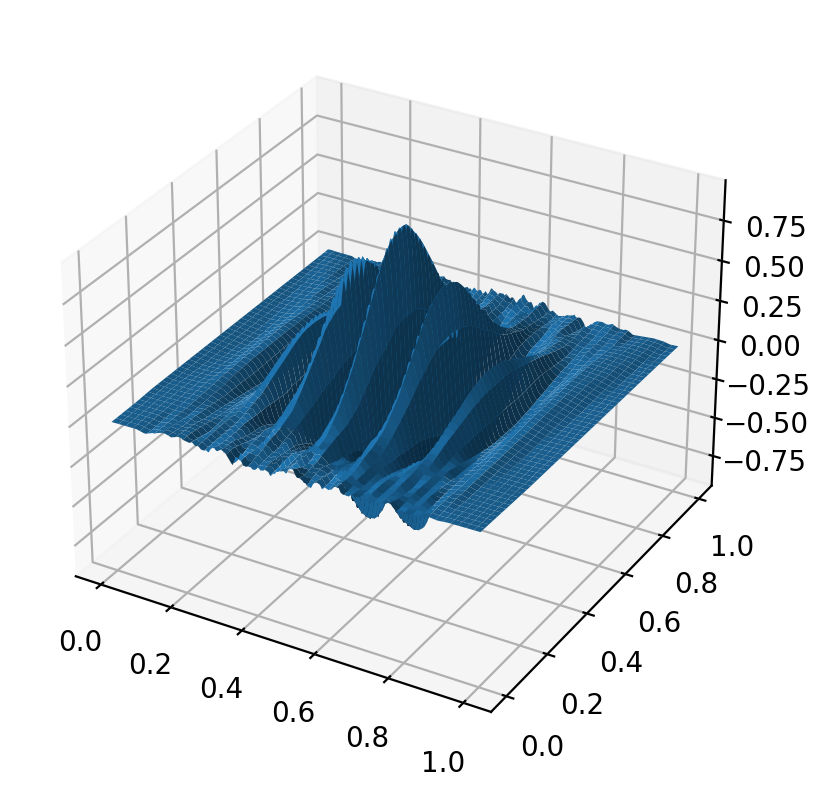

time taken:  115.49581623077393
neuron num 		 error 		 order
4 		 0.224309 		 * 		 10.296253 		 * 

8 		 0.232504 		 -0.051765 		 9.868380 		 0.061234 

16 		 0.172549 		 0.430248 		 8.286168 		 0.252108 

32 		 0.110762 		 0.639545 		 6.866884 		 0.271050 

64 		 0.057141 		 0.954851 		 4.790600 		 0.519449 

128 		 0.025517 		 1.163103 		 3.012846 		 0.669079 

256 		 0.011146 		 1.194970 		 1.899551 		 0.665468 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order & 	 $ | u -u_n |_{H^1}$ & 	 order \\ \hline \hline 
4 		 & 0.224309 &		 * & 		 10.296253 & 		 *  \\ \hline  

8 		 &  2.325e-01 &  		 -0.05 &  		 9.868e+00 &  		 0.06 \\ \hline  

16 		 &  1.725e-01 &  		 0.43 &  		 8.286e+00 &  		 0.25 \\ \hline  

32 		 &  1.108e-01 &  		 0.64 &  		 6.867e+00 &  		 0.27 \\ \hline  

64 		 &  5.714e-02 &  		 0.95 &  		 4.791e+00 &  		 0.52 \\ \hline  

128 		 &  2.552e-02 &  		 1.16 &  		 3.013e+00 &  		 0.67 \\ \hline  

256 		 &  1.115e-02 &  		 1.19 &  		 1.900e+00 &  		 0.67 \\ \hline  



In [39]:
import math 
sigma = 0.15
m = 8

def u_exact(x):
    """Gabor function applied to a batch of points."""
    exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
    cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])  # x[:, 0:1] keeps the dimension
    return exp_term * cos_term


def u_exact_grad():
    def u_grad_x(x):
        exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
        cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
        sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

        # Derivative with respect to x_1
        du_dx1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * cos_term - (2 * math.pi * m * exp_term * sin_term)
        return du_dx1
        
    def u_grad_y(x):

        exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
        cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
        sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])
        du_dx_other = exp_term * (-2 * (x[:, 1:2] - 0.5) / (2 * sigma ** 2)) * cos_term
        return du_dx_other

    u_grad=[] 
    u_grad.append(u_grad_x)
    u_grad.append(u_grad_y)
    return u_grad


def laplace_u_exact(x):
    """Laplacian of the Gabor function for a batch of points, summed over all dimensions."""

    exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
    cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
    sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

    # Laplacian in x_1: Apply the product rule twice
    laplace_x1_part_1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2))**2 * cos_term
    laplace_x1_part_2 = exp_term * ( - 1 / sigma ** 2) * cos_term
    laplace_x1_part_3 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * (-2*m*math.pi)*sin_term
    laplace_x1_part_4 = - (2 * math.pi * m * exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * sin_term) 
    laplace_x1_part_5 = - ( (2 * math.pi * m)**2 * exp_term * cos_term)

    laplace_x1 = laplace_x1_part_1 + laplace_x1_part_2 + laplace_x1_part_3 \
                + laplace_x1_part_4 + laplace_x1_part_5

    # Laplacian in other dimensions (x_i, i > 1): Only the exponential term matters here
    laplace_other = (-1 / sigma ** 2) * exp_term * cos_term \
                + exp_term * (-2 * (x[:, 1:] - 0.5) / (2 * sigma ** 2))**2 * cos_term 

    # Sum all Laplacians over each variable to get the total Laplacian
    laplace_sum = laplace_x1  + torch.sum(laplace_other, dim=1, keepdim=True)

    return laplace_sum 

def rhs(x):
    """Right-hand side of the equation using the Gabor function for a batch of points."""
    laplace_sum = laplace_u_exact(x)
    return -laplace_sum + nonlinear(u_exact(x))

def g_N(dim):
    u_grad = u_exact_grad() 
    bcs_N = []
    for i in range(dim):
        bcs_N.append((i, u_grad[i]))
    return bcs_N 


function_name = "gabor2d" 
filename_write = "data-neumann/2DOGA-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 
save = False 
relu_k = 1
for N_list in [[2*5,2**5]]: # ,[2**6,2**6],[2**7,2**7] 
    # save = True 
    f_write = open(filename_write, "a")
    my_model = None 
    Nx = 400  
    order = 3
    exponent = 8
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
    N = np.prod(N_list)
    err_QMC2, err_h10, my_model = CGANonlinearPoissonReLU2D(my_model,rhs,u_exact, u_exact_grad,g_N, N_list,num_epochs,plot_freq, Nx, order, k = relu_k, rand_deter = 'rand', linear_solver = "direct")
    if save: 
        folder = 'data-neumann/'
        filename = folder + 'err_OGA_2D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data-neumann/'
        filename = folder + 'model_OGA_2D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)

    show_convergence_order(err_QMC2,err_h10,exponent,N,filename_write,False)
    show_convergence_order_latex(err_QMC2,err_h10,exponent)

dim 2
using linear solver:  direct
epoch:  1	newton iteration:  1
torch.Size([1, 1])
sol_update_l2_norm:3.1362043707472946e-05 	 residual l2 norm: 0.007659404548430393 
newton iteration:  2
torch.Size([1, 1])
sol_update_l2_norm:2.0291544979296306e-12 	 residual l2 norm: 4.955708066134434e-10 
converged at iteration:  2
sol_update_l2_norm:2.0291544979296306e-12 	 residual l2 norm: 4.955708066134434e-10 
epoch:  2	newton iteration:  1
torch.Size([1, 2])
sol_update_l2_norm:0.00017380603330601442 	 residual l2 norm: 0.054228243973041164 
newton iteration:  2
torch.Size([1, 2])
sol_update_l2_norm:7.587186241047776e-11 	 residual l2 norm: 3.54890643797921e-08 
converged at iteration:  2
sol_update_l2_norm:7.587186241047776e-11 	 residual l2 norm: 3.54890643797921e-08 
epoch:  3	assembling the matrix time taken:  0.00016999244689941406
solving Ax = b time taken:  0.0006499290466308594
newton iteration:  1
torch.Size([1, 3])
sol_update_l2_norm:0.0008226744111065312 	 residual l2 norm: 0.012621

epoch:  16	assembling the matrix time taken:  0.0001728534698486328
solving Ax = b time taken:  0.0014848709106445312
newton iteration:  1
torch.Size([1, 16])
sol_update_l2_norm:6.201691698713375 	 residual l2 norm: 0.0034425052356693788 
newton iteration:  2
torch.Size([1, 16])
sol_update_l2_norm:4.2326387519246995e-06 	 residual l2 norm: 4.5933806504779204e-07 
newton iteration:  3
torch.Size([1, 16])
sol_update_l2_norm:2.1760140794659292e-10 	 residual l2 norm: 8.463358308545283e-14 
converged at iteration:  3
sol_update_l2_norm:2.1760140794659292e-10 	 residual l2 norm: 8.463358308545283e-14 
epoch:  17	assembling the matrix time taken:  0.00016689300537109375
solving Ax = b time taken:  0.0016148090362548828
newton iteration:  1
torch.Size([1, 17])
sol_update_l2_norm:3.5649869022626626 	 residual l2 norm: 0.0013222346045598877 
newton iteration:  2
torch.Size([1, 17])
sol_update_l2_norm:1.5514727469532269e-06 	 residual l2 norm: 6.401776184650105e-08 
newton iteration:  3
torch.Si

torch.Size([1, 30])
sol_update_l2_norm:0.0004180669461758591 	 residual l2 norm: 1.7513309984799662e-06 
newton iteration:  3
torch.Size([1, 30])
sol_update_l2_norm:2.102558036762776e-09 	 residual l2 norm: 1.2510630175576761e-12 
converged at iteration:  3
sol_update_l2_norm:2.102558036762776e-09 	 residual l2 norm: 1.2510630175576761e-12 
epoch:  31	assembling the matrix time taken:  0.0001723766326904297
solving Ax = b time taken:  0.0026063919067382812
newton iteration:  1
torch.Size([1, 31])
sol_update_l2_norm:773.7640739513339 	 residual l2 norm: 0.001874498360168314 
newton iteration:  2
torch.Size([1, 31])
sol_update_l2_norm:0.002730241922969477 	 residual l2 norm: 7.781241296863479e-05 
newton iteration:  3
torch.Size([1, 31])
sol_update_l2_norm:2.6734450560235593e-08 	 residual l2 norm: 2.7505832888183163e-12 
converged at iteration:  3
sol_update_l2_norm:2.6734450560235593e-08 	 residual l2 norm: 2.7505832888183163e-12 
epoch:  32	assembling the matrix time taken:  0.0001866

epoch:  45	assembling the matrix time taken:  0.00016355514526367188
solving Ax = b time taken:  0.003634214401245117
newton iteration:  1
torch.Size([1, 45])
sol_update_l2_norm:746.2667965748503 	 residual l2 norm: 0.002407555039390636 
newton iteration:  2
torch.Size([1, 45])
sol_update_l2_norm:0.0033494501222941773 	 residual l2 norm: 8.00172792990329e-05 
newton iteration:  3
torch.Size([1, 45])
sol_update_l2_norm:1.4067943169924872e-08 	 residual l2 norm: 1.3148397745492675e-12 
converged at iteration:  3
sol_update_l2_norm:1.4067943169924872e-08 	 residual l2 norm: 1.3148397745492675e-12 
epoch:  46	assembling the matrix time taken:  0.0001850128173828125
solving Ax = b time taken:  0.003660917282104492
newton iteration:  1
torch.Size([1, 46])
sol_update_l2_norm:79.9806569328435 	 residual l2 norm: 0.0016885057502009303 
newton iteration:  2
torch.Size([1, 46])
sol_update_l2_norm:0.0007366373293274552 	 residual l2 norm: 9.029565789276952e-06 
newton iteration:  3
torch.Size([1, 

epoch:  59	assembling the matrix time taken:  0.00016570091247558594
solving Ax = b time taken:  0.004642963409423828
newton iteration:  1
torch.Size([1, 59])
sol_update_l2_norm:648.5155442479356 	 residual l2 norm: 0.0009009012344143045 
newton iteration:  2
torch.Size([1, 59])
sol_update_l2_norm:0.0020927284016086715 	 residual l2 norm: 1.771465603716992e-05 
newton iteration:  3
torch.Size([1, 59])
sol_update_l2_norm:1.1240782828932615e-07 	 residual l2 norm: 3.38963055936156e-11 
converged at iteration:  3
sol_update_l2_norm:1.1240782828932615e-07 	 residual l2 norm: 3.38963055936156e-11 
epoch:  60	assembling the matrix time taken:  0.00017881393432617188
solving Ax = b time taken:  0.0047037601470947266
newton iteration:  1
torch.Size([1, 60])
sol_update_l2_norm:10916.27261934058 	 residual l2 norm: 0.0013988978455174168 
newton iteration:  2
torch.Size([1, 60])
sol_update_l2_norm:0.16199710037670337 	 residual l2 norm: 0.0018800595799707378 
newton iteration:  3
torch.Size([1, 6

epoch:  73	assembling the matrix time taken:  0.00017690658569335938
solving Ax = b time taken:  0.007628202438354492
newton iteration:  1
torch.Size([1, 73])
sol_update_l2_norm:3252.777658423344 	 residual l2 norm: 0.0006453787441173391 
newton iteration:  2
torch.Size([1, 73])
sol_update_l2_norm:0.009998722083131175 	 residual l2 norm: 2.872295097028065e-05 
newton iteration:  3
torch.Size([1, 73])
sol_update_l2_norm:1.6706090394328952e-07 	 residual l2 norm: 4.024946773188471e-12 
converged at iteration:  3
sol_update_l2_norm:1.6706090394328952e-07 	 residual l2 norm: 4.024946773188471e-12 
epoch:  74	assembling the matrix time taken:  0.00021910667419433594
solving Ax = b time taken:  0.00729823112487793
newton iteration:  1
torch.Size([1, 74])
sol_update_l2_norm:453.50976902905165 	 residual l2 norm: 0.0008084814690335908 
newton iteration:  2
torch.Size([1, 74])
sol_update_l2_norm:0.0007315200322825959 	 residual l2 norm: 2.113202257073953e-05 
newton iteration:  3
torch.Size([1,

epoch:  87	assembling the matrix time taken:  0.0001633167266845703
solving Ax = b time taken:  0.008820056915283203
newton iteration:  1
torch.Size([1, 87])
sol_update_l2_norm:808.9534937263885 	 residual l2 norm: 0.00067204441395233 
newton iteration:  2
torch.Size([1, 87])
sol_update_l2_norm:0.001969164999100154 	 residual l2 norm: 1.500918003060477e-06 
newton iteration:  3
torch.Size([1, 87])
sol_update_l2_norm:1.0508802747288492e-06 	 residual l2 norm: 3.4044190207809277e-12 
converged at iteration:  3
sol_update_l2_norm:1.0508802747288492e-06 	 residual l2 norm: 3.4044190207809277e-12 
epoch:  88	assembling the matrix time taken:  0.00018215179443359375
solving Ax = b time taken:  0.008750438690185547
newton iteration:  1
torch.Size([1, 88])
sol_update_l2_norm:3710.149592701848 	 residual l2 norm: 0.0005678423392116161 
newton iteration:  2
torch.Size([1, 88])
sol_update_l2_norm:0.012034535079932377 	 residual l2 norm: 3.5383131535396836e-05 
newton iteration:  3
torch.Size([1, 

torch.Size([1, 100])
sol_update_l2_norm:1.3813753791585235e-06 	 residual l2 norm: 3.79159093755559e-12 
converged at iteration:  3
sol_update_l2_norm:1.3813753791585235e-06 	 residual l2 norm: 3.79159093755559e-12 
epoch:  101	assembling the matrix time taken:  0.00016760826110839844
solving Ax = b time taken:  0.009186506271362305
newton iteration:  1
torch.Size([1, 101])
sol_update_l2_norm:355.8418968266603 	 residual l2 norm: 0.00024592628994927785 
newton iteration:  2
torch.Size([1, 101])
sol_update_l2_norm:0.000434688921210839 	 residual l2 norm: 9.431644521030363e-07 
newton iteration:  3
torch.Size([1, 101])
sol_update_l2_norm:9.040102424788325e-07 	 residual l2 norm: 2.1862754139858024e-11 
converged at iteration:  3
sol_update_l2_norm:9.040102424788325e-07 	 residual l2 norm: 2.1862754139858024e-11 
epoch:  102	assembling the matrix time taken:  0.00021123886108398438
solving Ax = b time taken:  0.009903192520141602
newton iteration:  1
torch.Size([1, 102])
sol_update_l2_nor

torch.Size([1, 113])
sol_update_l2_norm:2.521019508381022e-06 	 residual l2 norm: 9.938394533398274e-12 
converged at iteration:  3
sol_update_l2_norm:2.521019508381022e-06 	 residual l2 norm: 9.938394533398274e-12 
epoch:  114	assembling the matrix time taken:  0.0001766681671142578
solving Ax = b time taken:  0.010846614837646484
newton iteration:  1
torch.Size([1, 114])
sol_update_l2_norm:14764.31879370896 	 residual l2 norm: 0.00016467307567218396 
newton iteration:  2
torch.Size([1, 114])
sol_update_l2_norm:0.013575084135667333 	 residual l2 norm: 2.0412311296024762e-05 
newton iteration:  3
torch.Size([1, 114])
sol_update_l2_norm:2.4738731455752904e-06 	 residual l2 norm: 2.665949388179237e-11 
converged at iteration:  3
sol_update_l2_norm:2.4738731455752904e-06 	 residual l2 norm: 2.665949388179237e-11 
epoch:  115	assembling the matrix time taken:  0.00016069412231445312
solving Ax = b time taken:  0.010166645050048828
newton iteration:  1
torch.Size([1, 115])
sol_update_l2_nor

torch.Size([1, 125])
sol_update_l2_norm:4.2192794947005445e-06 	 residual l2 norm: 3.658927031749772e-12 
converged at iteration:  5
sol_update_l2_norm:4.2192794947005445e-06 	 residual l2 norm: 3.658927031749772e-12 
epoch:  126	assembling the matrix time taken:  0.00015616416931152344
solving Ax = b time taken:  0.010726213455200195
newton iteration:  1
torch.Size([1, 126])
sol_update_l2_norm:1373.1093745153516 	 residual l2 norm: 0.0001302935500525914 
newton iteration:  2
torch.Size([1, 126])
sol_update_l2_norm:0.0003974008590218546 	 residual l2 norm: 3.6979743261040677e-07 
newton iteration:  3
torch.Size([1, 126])
sol_update_l2_norm:4.03210984295468e-06 	 residual l2 norm: 2.461978741553602e-12 
converged at iteration:  3
sol_update_l2_norm:4.03210984295468e-06 	 residual l2 norm: 2.461978741553602e-12 
epoch:  127	assembling the matrix time taken:  0.0001537799835205078
solving Ax = b time taken:  0.010818958282470703
newton iteration:  1
torch.Size([1, 127])
sol_update_l2_norm

epoch:  139	assembling the matrix time taken:  0.0001571178436279297
solving Ax = b time taken:  0.01483774185180664
newton iteration:  1
torch.Size([1, 139])
sol_update_l2_norm:245.88012725598915 	 residual l2 norm: 0.00010351498118169763 
newton iteration:  2
torch.Size([1, 139])
sol_update_l2_norm:0.0003976340948962699 	 residual l2 norm: 2.18606763937577e-08 
newton iteration:  3
torch.Size([1, 139])
sol_update_l2_norm:5.85863286678543e-06 	 residual l2 norm: 1.408599428205347e-11 
newton iteration:  4
torch.Size([1, 139])
sol_update_l2_norm:7.984434700609884e-07 	 residual l2 norm: 2.1047735994100916e-11 
converged at iteration:  4
sol_update_l2_norm:7.984434700609884e-07 	 residual l2 norm: 2.1047735994100916e-11 
epoch:  140	assembling the matrix time taken:  0.00017380714416503906
solving Ax = b time taken:  0.014026165008544922
newton iteration:  1
torch.Size([1, 140])
sol_update_l2_norm:614.3154869326166 	 residual l2 norm: 0.00010521189425729722 
newton iteration:  2
torch.S

solving Ax = b time taken:  0.015552043914794922
newton iteration:  1
torch.Size([1, 152])
sol_update_l2_norm:476.6597466353395 	 residual l2 norm: 5.405604419986961e-05 
newton iteration:  2
torch.Size([1, 152])
sol_update_l2_norm:0.00024349145627170917 	 residual l2 norm: 4.84488359081958e-08 
newton iteration:  3
torch.Size([1, 152])
sol_update_l2_norm:4.220199375800659e-06 	 residual l2 norm: 6.134675482530325e-11 
converged at iteration:  3
sol_update_l2_norm:4.220199375800659e-06 	 residual l2 norm: 6.134675482530325e-11 
epoch:  153	assembling the matrix time taken:  0.0001575946807861328
solving Ax = b time taken:  0.015672683715820312
newton iteration:  1
torch.Size([1, 153])
sol_update_l2_norm:1289.1053001426383 	 residual l2 norm: 7.161708398804117e-05 
newton iteration:  2
torch.Size([1, 153])
sol_update_l2_norm:0.001923672524379225 	 residual l2 norm: 2.165184732940586e-07 
newton iteration:  3
torch.Size([1, 153])
sol_update_l2_norm:1.7159362381179232e-06 	 residual l2 no

torch.Size([1, 164])
sol_update_l2_norm:0.006135851147204843 	 residual l2 norm: 2.8979118716158037e-05 
newton iteration:  3
torch.Size([1, 164])
sol_update_l2_norm:4.0646420884466034e-06 	 residual l2 norm: 5.36224643375102e-11 
converged at iteration:  3
sol_update_l2_norm:4.0646420884466034e-06 	 residual l2 norm: 5.36224643375102e-11 
epoch:  165	assembling the matrix time taken:  0.00015354156494140625
solving Ax = b time taken:  0.016408681869506836
newton iteration:  1
torch.Size([1, 165])
sol_update_l2_norm:303.89714881900153 	 residual l2 norm: 7.052100918125031e-05 
newton iteration:  2
torch.Size([1, 165])
sol_update_l2_norm:0.0005586614360710891 	 residual l2 norm: 5.299513032704922e-08 
newton iteration:  3
torch.Size([1, 165])
sol_update_l2_norm:5.556122780717254e-06 	 residual l2 norm: 5.2250961264273193e-11 
newton iteration:  4
torch.Size([1, 165])
sol_update_l2_norm:5.53815090727736e-06 	 residual l2 norm: 3.808456340207471e-11 
newton iteration:  5
torch.Size([1, 16

epoch:  176	assembling the matrix time taken:  0.0001823902130126953
solving Ax = b time taken:  0.01700425148010254
newton iteration:  1
torch.Size([1, 176])
sol_update_l2_norm:116.3083351572291 	 residual l2 norm: 6.605320175193012e-05 
newton iteration:  2
torch.Size([1, 176])
sol_update_l2_norm:0.0003805258099716656 	 residual l2 norm: 2.457637206559343e-08 
newton iteration:  3
torch.Size([1, 176])
sol_update_l2_norm:8.594815200835155e-06 	 residual l2 norm: 6.319250459950003e-11 
newton iteration:  4
torch.Size([1, 176])
sol_update_l2_norm:2.7475455256585247e-06 	 residual l2 norm: 3.2321215855298687e-11 
converged at iteration:  4
sol_update_l2_norm:2.7475455256585247e-06 	 residual l2 norm: 3.2321215855298687e-11 
epoch:  177	assembling the matrix time taken:  0.0001857280731201172
solving Ax = b time taken:  0.017138957977294922
newton iteration:  1
torch.Size([1, 177])
sol_update_l2_norm:692.5354067844423 	 residual l2 norm: 9.908174459489141e-05 
newton iteration:  2
torch.S

epoch:  188	assembling the matrix time taken:  0.00020241737365722656
solving Ax = b time taken:  0.017790555953979492
newton iteration:  1
torch.Size([1, 188])
sol_update_l2_norm:3629.9580391752515 	 residual l2 norm: 0.0004302737140537045 
newton iteration:  2
torch.Size([1, 188])
sol_update_l2_norm:0.005158684875993536 	 residual l2 norm: 2.655320652239516e-06 
newton iteration:  3
torch.Size([1, 188])
sol_update_l2_norm:1.671888732644311e-05 	 residual l2 norm: 4.6038887530238606e-11 
newton iteration:  4
torch.Size([1, 188])
sol_update_l2_norm:1.0234528122985884e-05 	 residual l2 norm: 5.158425060529579e-11 
newton iteration:  5
torch.Size([1, 188])
sol_update_l2_norm:1.3747154947376012e-06 	 residual l2 norm: 3.98691730741865e-11 
converged at iteration:  5
sol_update_l2_norm:1.3747154947376012e-06 	 residual l2 norm: 3.98691730741865e-11 
epoch:  189	assembling the matrix time taken:  0.00021266937255859375
solving Ax = b time taken:  0.017868757247924805
newton iteration:  1
to

torch.Size([1, 198])
sol_update_l2_norm:4.27571774266041e-06 	 residual l2 norm: 2.4905473003882597e-11 
converged at iteration:  3
sol_update_l2_norm:4.27571774266041e-06 	 residual l2 norm: 2.4905473003882597e-11 
epoch:  199	assembling the matrix time taken:  0.00019598007202148438
solving Ax = b time taken:  0.024140119552612305
newton iteration:  1
torch.Size([1, 199])
sol_update_l2_norm:397.9538120779675 	 residual l2 norm: 5.899476114095081e-05 
newton iteration:  2
torch.Size([1, 199])
sol_update_l2_norm:0.000871884474668844 	 residual l2 norm: 3.443125087196621e-08 
newton iteration:  3
torch.Size([1, 199])
sol_update_l2_norm:1.3283789852488862e-05 	 residual l2 norm: 8.469120438339487e-11 
newton iteration:  4
torch.Size([1, 199])
sol_update_l2_norm:8.283232903032552e-06 	 residual l2 norm: 2.952498760124557e-11 
newton iteration:  5
torch.Size([1, 199])
sol_update_l2_norm:7.23929332939424e-06 	 residual l2 norm: 1.3630035042129772e-11 
newton iteration:  6
torch.Size([1, 199

torch.Size([1, 208])
sol_update_l2_norm:7.169941992157732e-06 	 residual l2 norm: 3.876537969452543e-11 
newton iteration:  6
torch.Size([1, 208])
sol_update_l2_norm:4.1322219177366415e-06 	 residual l2 norm: 2.4721119857560216e-11 
converged at iteration:  6
sol_update_l2_norm:4.1322219177366415e-06 	 residual l2 norm: 2.4721119857560216e-11 
epoch:  209	assembling the matrix time taken:  0.0001728534698486328
solving Ax = b time taken:  0.024888038635253906
newton iteration:  1
torch.Size([1, 209])
sol_update_l2_norm:392.07398851178976 	 residual l2 norm: 5.999205223465976e-05 
newton iteration:  2
torch.Size([1, 209])
sol_update_l2_norm:0.0007782042052927526 	 residual l2 norm: 1.6860728843941852e-07 
newton iteration:  3
torch.Size([1, 209])
sol_update_l2_norm:9.348424518994814e-06 	 residual l2 norm: 7.560949119672206e-12 
newton iteration:  4
torch.Size([1, 209])
sol_update_l2_norm:1.38653260167893e-05 	 residual l2 norm: 2.8993308005990928e-11 
newton iteration:  5
torch.Size([1

torch.Size([1, 216])
sol_update_l2_norm:2.0885761955691207e-05 	 residual l2 norm: 5.213517765010046e-11 
newton iteration:  4
torch.Size([1, 216])
sol_update_l2_norm:4.023197309205308e-06 	 residual l2 norm: 1.0445011701453025e-11 
converged at iteration:  4
sol_update_l2_norm:4.023197309205308e-06 	 residual l2 norm: 1.0445011701453025e-11 
epoch:  217	assembling the matrix time taken:  0.0001728534698486328
solving Ax = b time taken:  0.025335311889648438
newton iteration:  1
torch.Size([1, 217])
sol_update_l2_norm:871.0583229596552 	 residual l2 norm: 5.613787809482371e-05 
newton iteration:  2
torch.Size([1, 217])
sol_update_l2_norm:0.0027605678465633925 	 residual l2 norm: 1.1399098931042122e-07 
newton iteration:  3
torch.Size([1, 217])
sol_update_l2_norm:8.212848167576282e-05 	 residual l2 norm: 4.69944250097728e-11 
newton iteration:  4
torch.Size([1, 217])
sol_update_l2_norm:3.722606670878132e-05 	 residual l2 norm: 3.9564587035986876e-11 
newton iteration:  5
torch.Size([1, 

torch.Size([1, 220])
sol_update_l2_norm:1.2450258709502666e-05 	 residual l2 norm: 3.40933721300774e-11 
newton iteration:  8
torch.Size([1, 220])
sol_update_l2_norm:1.6032013129172383e-05 	 residual l2 norm: 2.908370814756061e-11 
newton iteration:  9
torch.Size([1, 220])
sol_update_l2_norm:2.8923894905664063e-05 	 residual l2 norm: 7.669823868371606e-11 
newton iteration:  10
torch.Size([1, 220])
sol_update_l2_norm:4.4181952292693096e-05 	 residual l2 norm: 4.877599018654597e-11 
newton iteration:  11
torch.Size([1, 220])
sol_update_l2_norm:1.5943780999506464e-05 	 residual l2 norm: 3.881320688729566e-11 
newton iteration:  12
torch.Size([1, 220])
sol_update_l2_norm:4.757161962717017e-05 	 residual l2 norm: 5.332349568977082e-11 
newton iteration:  13
torch.Size([1, 220])
sol_update_l2_norm:2.7320483690341204e-05 	 residual l2 norm: 2.645284408226757e-11 
newton iteration:  14
torch.Size([1, 220])
sol_update_l2_norm:5.438902945638518e-06 	 residual l2 norm: 2.0853262743966696e-11 
ne

torch.Size([1, 223])
sol_update_l2_norm:1.612406403413118e-05 	 residual l2 norm: 2.4652982825871896e-11 
newton iteration:  12
torch.Size([1, 223])
sol_update_l2_norm:2.0778864597550574e-05 	 residual l2 norm: 1.920055699527148e-11 
newton iteration:  13
torch.Size([1, 223])
sol_update_l2_norm:1.0730871320522727e-05 	 residual l2 norm: 1.1117371553161902e-11 
newton iteration:  14
torch.Size([1, 223])
sol_update_l2_norm:1.6246651562885243e-05 	 residual l2 norm: 2.8502875276130932e-11 
newton iteration:  15
torch.Size([1, 223])
sol_update_l2_norm:2.077601998493552e-05 	 residual l2 norm: 4.433856988200055e-12 
newton iteration:  16
torch.Size([1, 223])
sol_update_l2_norm:1.9970339203045355e-05 	 residual l2 norm: 1.3351364939867607e-11 
newton iteration:  17
torch.Size([1, 223])
sol_update_l2_norm:3.5881895673908214e-05 	 residual l2 norm: 3.0104513821356627e-11 
newton iteration:  18
torch.Size([1, 223])
sol_update_l2_norm:4.6009324254049364e-05 	 residual l2 norm: 1.717057276087288e

epoch:  227	assembling the matrix time taken:  0.00018310546875
solving Ax = b time taken:  0.025958538055419922
newton iteration:  1
torch.Size([1, 227])
sol_update_l2_norm:6552.930155695633 	 residual l2 norm: 2.6282833136971528e-05 
newton iteration:  2
torch.Size([1, 227])
sol_update_l2_norm:0.013453648282014013 	 residual l2 norm: 2.9601281575933053e-07 
newton iteration:  3
torch.Size([1, 227])
sol_update_l2_norm:9.594910688704533e-06 	 residual l2 norm: 1.2199938704038925e-11 
newton iteration:  4
torch.Size([1, 227])
sol_update_l2_norm:9.934258436076347e-06 	 residual l2 norm: 1.0722834116290436e-11 
newton iteration:  5
torch.Size([1, 227])
sol_update_l2_norm:7.223535295338204e-06 	 residual l2 norm: 4.2542070971330136e-11 
newton iteration:  6
torch.Size([1, 227])
sol_update_l2_norm:5.464866380099529e-06 	 residual l2 norm: 1.141872381255952e-11 
newton iteration:  7
torch.Size([1, 227])
sol_update_l2_norm:1.8066476991613372e-05 	 residual l2 norm: 3.918672289227814e-11 
newt

torch.Size([1, 231])
sol_update_l2_norm:7.234888892865539e-06 	 residual l2 norm: 1.269757408734438e-11 
newton iteration:  12
torch.Size([1, 231])
sol_update_l2_norm:1.1749856465566337e-05 	 residual l2 norm: 2.012290050695812e-11 
newton iteration:  13
torch.Size([1, 231])
sol_update_l2_norm:1.540570393941224e-05 	 residual l2 norm: 1.6600229335314976e-11 
newton iteration:  14
torch.Size([1, 231])
sol_update_l2_norm:6.576130542337673e-06 	 residual l2 norm: 1.2535995006506746e-11 
newton iteration:  15
torch.Size([1, 231])
sol_update_l2_norm:7.232765119441786e-06 	 residual l2 norm: 1.5788004078331066e-11 
newton iteration:  16
torch.Size([1, 231])
sol_update_l2_norm:1.6870834568280612e-05 	 residual l2 norm: 8.265469401267371e-12 
newton iteration:  17
torch.Size([1, 231])
sol_update_l2_norm:5.050348858883687e-06 	 residual l2 norm: 1.6033092598946036e-11 
newton iteration:  18
torch.Size([1, 231])
sol_update_l2_norm:1.63182972424902e-05 	 residual l2 norm: 7.641653568815878e-12 
n

epoch:  236	assembling the matrix time taken:  0.00030517578125
solving Ax = b time taken:  0.026859521865844727
newton iteration:  1
torch.Size([1, 236])
sol_update_l2_norm:1289.5392386874091 	 residual l2 norm: 6.346654512159834e-05 
newton iteration:  2
torch.Size([1, 236])
sol_update_l2_norm:0.006876848179824317 	 residual l2 norm: 9.523303459674561e-08 
newton iteration:  3
torch.Size([1, 236])
sol_update_l2_norm:1.4070354839051406e-05 	 residual l2 norm: 2.3632543478275573e-11 
newton iteration:  4
torch.Size([1, 236])
sol_update_l2_norm:8.009697585934768e-06 	 residual l2 norm: 5.8566578898191485e-12 
newton iteration:  5
torch.Size([1, 236])
sol_update_l2_norm:1.534570695777665e-05 	 residual l2 norm: 1.3136415564222013e-11 
newton iteration:  6
torch.Size([1, 236])
sol_update_l2_norm:6.848586492910815e-06 	 residual l2 norm: 1.2475292672532991e-11 
newton iteration:  7
torch.Size([1, 236])
sol_update_l2_norm:6.858575663985246e-06 	 residual l2 norm: 3.059328140051417e-11 
newt

torch.Size([1, 239])
sol_update_l2_norm:4.118843434933494e-05 	 residual l2 norm: 5.567024731901583e-12 
newton iteration:  14
torch.Size([1, 239])
sol_update_l2_norm:6.579543023058034e-06 	 residual l2 norm: 8.92236424203682e-12 
newton iteration:  15
torch.Size([1, 239])
sol_update_l2_norm:1.8777852783150157e-05 	 residual l2 norm: 1.6359942903576782e-11 
newton iteration:  16
torch.Size([1, 239])
sol_update_l2_norm:1.8085603783539646e-05 	 residual l2 norm: 1.2252934031833387e-11 
newton iteration:  17
torch.Size([1, 239])
sol_update_l2_norm:1.2620549956797482e-05 	 residual l2 norm: 1.251625470262063e-11 
newton iteration:  18
torch.Size([1, 239])
sol_update_l2_norm:1.8584198784477652e-05 	 residual l2 norm: 6.878696661859773e-12 
newton iteration:  19
torch.Size([1, 239])
sol_update_l2_norm:1.1710132981277709e-05 	 residual l2 norm: 1.2833467624513804e-11 
newton iteration:  20
torch.Size([1, 239])
sol_update_l2_norm:5.50973798783735e-06 	 residual l2 norm: 3.1436772504306503e-12 

torch.Size([1, 242])
sol_update_l2_norm:3.2189974406824074e-05 	 residual l2 norm: 1.9194846229313995e-11 
newton iteration:  14
torch.Size([1, 242])
sol_update_l2_norm:5.882228502315819e-05 	 residual l2 norm: 9.824229827709879e-12 
newton iteration:  15
torch.Size([1, 242])
sol_update_l2_norm:4.025136997131572e-05 	 residual l2 norm: 2.5357501433503838e-11 
newton iteration:  16
torch.Size([1, 242])
sol_update_l2_norm:2.2760139862617502e-05 	 residual l2 norm: 6.049609147707705e-12 
newton iteration:  17
torch.Size([1, 242])
sol_update_l2_norm:7.552074592216695e-05 	 residual l2 norm: 2.3499247558148886e-11 
newton iteration:  18
torch.Size([1, 242])
sol_update_l2_norm:2.2487620793559953e-05 	 residual l2 norm: 1.6511647206524465e-11 
newton iteration:  19
torch.Size([1, 242])
sol_update_l2_norm:4.2057219180910686e-05 	 residual l2 norm: 1.763449709322223e-12 
newton iteration:  20
torch.Size([1, 242])
sol_update_l2_norm:3.859689110024203e-05 	 residual l2 norm: 1.4117067532261024e-1

torch.Size([1, 245])
sol_update_l2_norm:0.00013912361393462238 	 residual l2 norm: 2.0448756907793086e-11 
newton iteration:  14
torch.Size([1, 245])
sol_update_l2_norm:6.272203598642453e-05 	 residual l2 norm: 4.670218180563102e-11 
newton iteration:  15
torch.Size([1, 245])
sol_update_l2_norm:2.8224431446961646e-05 	 residual l2 norm: 8.704782507278924e-12 
newton iteration:  16
torch.Size([1, 245])
sol_update_l2_norm:3.413284220256655e-05 	 residual l2 norm: 2.1172275912295453e-11 
newton iteration:  17
torch.Size([1, 245])
sol_update_l2_norm:3.0343005630791644e-05 	 residual l2 norm: 6.4875872775670176e-12 
newton iteration:  18
torch.Size([1, 245])
sol_update_l2_norm:4.00208802854069e-05 	 residual l2 norm: 2.6425207650724633e-11 
newton iteration:  19
torch.Size([1, 245])
sol_update_l2_norm:0.00011813397902993204 	 residual l2 norm: 1.2643412117749195e-11 
newton iteration:  20
torch.Size([1, 245])
sol_update_l2_norm:1.0551400011260729e-05 	 residual l2 norm: 1.898851273590765e-1

torch.Size([1, 248])
sol_update_l2_norm:3.205293884078444e-05 	 residual l2 norm: 1.4497052178953105e-11 
newton iteration:  14
torch.Size([1, 248])
sol_update_l2_norm:3.662789445813984e-05 	 residual l2 norm: 6.76332480572517e-11 
newton iteration:  15
torch.Size([1, 248])
sol_update_l2_norm:1.7299167002651957e-05 	 residual l2 norm: 1.849092963150287e-11 
newton iteration:  16
torch.Size([1, 248])
sol_update_l2_norm:5.3635069581566126e-05 	 residual l2 norm: 2.3071757083496558e-11 
newton iteration:  17
torch.Size([1, 248])
sol_update_l2_norm:6.601350329639194e-05 	 residual l2 norm: 4.604932764599045e-12 
newton iteration:  18
torch.Size([1, 248])
sol_update_l2_norm:3.603210201046806e-05 	 residual l2 norm: 2.877289280991322e-12 
newton iteration:  19
torch.Size([1, 248])
sol_update_l2_norm:6.914225341447861e-05 	 residual l2 norm: 4.071077594853975e-11 
newton iteration:  20
torch.Size([1, 248])
sol_update_l2_norm:0.00010330111808548253 	 residual l2 norm: 3.257418981587943e-11 
Ne

torch.Size([1, 251])
sol_update_l2_norm:4.848582058274165e-05 	 residual l2 norm: 1.9277932854635812e-11 
newton iteration:  14
torch.Size([1, 251])
sol_update_l2_norm:6.286392490524549e-05 	 residual l2 norm: 2.492381637843197e-11 
newton iteration:  15
torch.Size([1, 251])
sol_update_l2_norm:9.213245298498591e-05 	 residual l2 norm: 4.029866672215264e-12 
newton iteration:  16
torch.Size([1, 251])
sol_update_l2_norm:0.00013663597957772118 	 residual l2 norm: 1.9846483506835155e-11 
newton iteration:  17
torch.Size([1, 251])
sol_update_l2_norm:3.057897131913718e-05 	 residual l2 norm: 2.5346252090823468e-11 
newton iteration:  18
torch.Size([1, 251])
sol_update_l2_norm:2.2607959716460564e-05 	 residual l2 norm: 2.5671338072737714e-11 
newton iteration:  19
torch.Size([1, 251])
sol_update_l2_norm:8.545506338527901e-05 	 residual l2 norm: 2.7028568746537414e-11 
newton iteration:  20
torch.Size([1, 251])
sol_update_l2_norm:0.00010112911727650551 	 residual l2 norm: 3.212148481598273e-11

torch.Size([1, 254])
sol_update_l2_norm:2.1875508907256437e-05 	 residual l2 norm: 2.8624893717850126e-12 
newton iteration:  13
torch.Size([1, 254])
sol_update_l2_norm:5.362634338942503e-05 	 residual l2 norm: 1.1939797618500748e-11 
newton iteration:  14
torch.Size([1, 254])
sol_update_l2_norm:5.9751448735029086e-05 	 residual l2 norm: 2.777502079394784e-11 
newton iteration:  15
torch.Size([1, 254])
sol_update_l2_norm:2.26112566112732e-05 	 residual l2 norm: 8.853929955884247e-12 
newton iteration:  16
torch.Size([1, 254])
sol_update_l2_norm:5.231295934014504e-05 	 residual l2 norm: 1.3111406442425602e-11 
newton iteration:  17
torch.Size([1, 254])
sol_update_l2_norm:1.3265887160575945e-05 	 residual l2 norm: 1.3965090036142643e-11 
newton iteration:  18
torch.Size([1, 254])
sol_update_l2_norm:4.449780400372042e-05 	 residual l2 norm: 1.3728440675099972e-11 
newton iteration:  19
torch.Size([1, 254])
sol_update_l2_norm:8.037256682365433e-05 	 residual l2 norm: 2.1729251095533305e-11

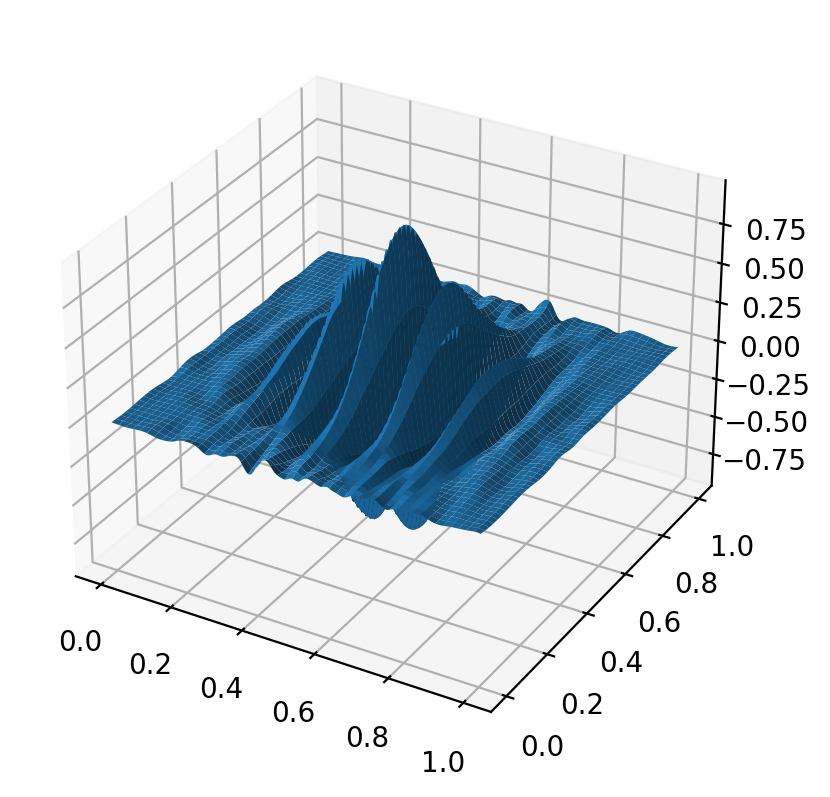

time taken:  262.1206178665161
neuron num 		 error 		 order
4 		 0.188002 		 * 		 10.377405 		 * 

8 		 0.188007 		 -0.000035 		 10.377392 		 0.000002 

16 		 0.188326 		 -0.002446 		 10.376454 		 0.000130 

32 		 0.192042 		 -0.028189 		 10.308332 		 0.009503 

64 		 0.158417 		 0.277696 		 8.499386 		 0.278380 

128 		 0.041481 		 1.933204 		 3.108882 		 1.450963 

256 		 0.009091 		 2.189877 		 0.982302 		 1.662158 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order & 	 $ | u -u_n |_{H^1}$ & 	 order \\ \hline \hline 
4 		 & 0.188002 &		 * & 		 10.377405 & 		 *  \\ \hline  

8 		 &  1.880e-01 &  		 -0.00 &  		 1.038e+01 &  		 0.00 \\ \hline  

16 		 &  1.883e-01 &  		 -0.00 &  		 1.038e+01 &  		 0.00 \\ \hline  

32 		 &  1.920e-01 &  		 -0.03 &  		 1.031e+01 &  		 0.01 \\ \hline  

64 		 &  1.584e-01 &  		 0.28 &  		 8.499e+00 &  		 0.28 \\ \hline  

128 		 &  4.148e-02 &  		 1.93 &  		 3.109e+00 &  		 1.45 \\ \hline  

256 		 &  9.091e-03 &  		 2.19 &  		 9.823e-01 &  		 1.66 \\ \hline 

In [40]:
import math 
sigma = 0.15
m = 8

def u_exact(x):
    """Gabor function applied to a batch of points."""
    exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
    cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])  # x[:, 0:1] keeps the dimension
    return exp_term * cos_term


def u_exact_grad():
    def u_grad_x(x):
        exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
        cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
        sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

        # Derivative with respect to x_1
        du_dx1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * cos_term - (2 * math.pi * m * exp_term * sin_term)
        return du_dx1
        
    def u_grad_y(x):

        exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
        cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
        sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])
        du_dx_other = exp_term * (-2 * (x[:, 1:2] - 0.5) / (2 * sigma ** 2)) * cos_term
        return du_dx_other

    u_grad=[] 
    u_grad.append(u_grad_x)
    u_grad.append(u_grad_y)
    return u_grad


def laplace_u_exact(x):
    """Laplacian of the Gabor function for a batch of points, summed over all dimensions."""

    exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
    cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
    sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

    # Laplacian in x_1: Apply the product rule twice
    laplace_x1_part_1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2))**2 * cos_term
    laplace_x1_part_2 = exp_term * ( - 1 / sigma ** 2) * cos_term
    laplace_x1_part_3 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * (-2*m*math.pi)*sin_term
    laplace_x1_part_4 = - (2 * math.pi * m * exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * sin_term) 
    laplace_x1_part_5 = - ( (2 * math.pi * m)**2 * exp_term * cos_term)

    laplace_x1 = laplace_x1_part_1 + laplace_x1_part_2 + laplace_x1_part_3 \
                + laplace_x1_part_4 + laplace_x1_part_5

    # Laplacian in other dimensions (x_i, i > 1): Only the exponential term matters here
    laplace_other = (-1 / sigma ** 2) * exp_term * cos_term \
                + exp_term * (-2 * (x[:, 1:] - 0.5) / (2 * sigma ** 2))**2 * cos_term 

    # Sum all Laplacians over each variable to get the total Laplacian
    laplace_sum = laplace_x1  + torch.sum(laplace_other, dim=1, keepdim=True)

    return laplace_sum 

def rhs(x):
    """Right-hand side of the equation using the Gabor function for a batch of points."""
    laplace_sum = laplace_u_exact(x)
    return -laplace_sum + nonlinear(u_exact(x))

def g_N(dim):
    u_grad = u_exact_grad() 
    bcs_N = []
    for i in range(dim):
        bcs_N.append((i, u_grad[i]))
    return bcs_N 


function_name = "gabor2d" 
filename_write = "data-neumann/2DOGA-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 
save = False 
relu_k = 3 
for N_list in [[2*5,2**5]]: # ,[2**6,2**6],[2**7,2**7] 
    # save = True 
    f_write = open(filename_write, "a")
    my_model = None 
    Nx = 400  
    order = 3
    exponent = 8
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
    N = np.prod(N_list)
    err_QMC2, err_h10, my_model = CGANonlinearPoissonReLU2D(my_model,rhs,u_exact, u_exact_grad,g_N, N_list,num_epochs,plot_freq, Nx, order, k = relu_k, rand_deter = 'rand', linear_solver = "direct")
    if save: 
        folder = 'data-neumann/'
        filename = folder + 'err_OGA_2D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data-neumann/'
        filename = folder + 'model_OGA_2D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)

    show_convergence_order(err_QMC2,err_h10,exponent,N,filename_write,False)
    show_convergence_order_latex(err_QMC2,err_h10,exponent)

In [42]:
## 
k = 3
d =2 
l2_order = 0.5 + (2*k+1)/(2*d)
print(l2_order)
h1_order = 0.5 + (2*(k-1)+1)/(2*d)
print(h1_order)

2.25
1.75


## cosine example 

dim 2
using linear solver:  direct
epoch:  1	newton iteration:  1
torch.Size([1, 1])
sol_update_l2_norm:2.7832233608703447 	 residual l2 norm: 0.15773855936944323 
newton iteration:  2
torch.Size([1, 1])
sol_update_l2_norm:0.0026667738237656506 	 residual l2 norm: 0.00015157942975521643 
newton iteration:  3
torch.Size([1, 1])
sol_update_l2_norm:7.63388243656624e-09 	 residual l2 norm: 4.3390741000237654e-10 
newton iteration:  4
torch.Size([1, 1])
sol_update_l2_norm:0.0 	 residual l2 norm: 0.0 
converged at iteration:  4
sol_update_l2_norm:0.0 	 residual l2 norm: 0.0 
epoch:  2	newton iteration:  1
torch.Size([1, 2])
sol_update_l2_norm:3.8840804712781347 	 residual l2 norm: 0.15937616027688595 
newton iteration:  2
torch.Size([1, 2])
sol_update_l2_norm:0.004266730002634157 	 residual l2 norm: 0.021740901692825575 
newton iteration:  3
torch.Size([1, 2])
sol_update_l2_norm:2.307634336601385e-07 	 residual l2 norm: 1.2787106018601304e-06 
newton iteration:  4
torch.Size([1, 2])
sol_upda

torch.Size([1, 15])
sol_update_l2_norm:3.25060489922253e-08 	 residual l2 norm: 1.4101692881525051e-08 
newton iteration:  4
torch.Size([1, 15])
sol_update_l2_norm:3.1208709914613174e-12 	 residual l2 norm: 1.701193032783005e-14 
converged at iteration:  4
sol_update_l2_norm:3.1208709914613174e-12 	 residual l2 norm: 1.701193032783005e-14 
epoch:  16	assembling the matrix time taken:  0.0001583099365234375
solving Ax = b time taken:  0.0006897449493408203
newton iteration:  1
torch.Size([1, 16])
sol_update_l2_norm:125.2243694600968 	 residual l2 norm: 0.025105905041252784 
newton iteration:  2
torch.Size([1, 16])
sol_update_l2_norm:0.011719367030882924 	 residual l2 norm: 0.005808787772315117 
newton iteration:  3
torch.Size([1, 16])
sol_update_l2_norm:1.9195764701191574e-07 	 residual l2 norm: 6.545595743934312e-08 
newton iteration:  4
torch.Size([1, 16])
sol_update_l2_norm:3.982711855836928e-12 	 residual l2 norm: 2.375377538577201e-13 
converged at iteration:  4
sol_update_l2_norm:

epoch:  31	assembling the matrix time taken:  0.00015807151794433594
solving Ax = b time taken:  0.0011756420135498047
newton iteration:  1
torch.Size([1, 31])
sol_update_l2_norm:53.99892826527465 	 residual l2 norm: 0.0007070275819281945 
newton iteration:  2
torch.Size([1, 31])
sol_update_l2_norm:0.0005122474027553825 	 residual l2 norm: 1.6999092729625584e-05 
newton iteration:  3
torch.Size([1, 31])
sol_update_l2_norm:1.3343673545575237e-11 	 residual l2 norm: 1.8294566980964376e-12 
converged at iteration:  3
sol_update_l2_norm:1.3343673545575237e-11 	 residual l2 norm: 1.8294566980964376e-12 
epoch:  32	assembling the matrix time taken:  0.00016260147094726562
solving Ax = b time taken:  0.0012235641479492188
newton iteration:  1
torch.Size([1, 32])
sol_update_l2_norm:28.238681171486835 	 residual l2 norm: 0.00036567693785729 
newton iteration:  2
torch.Size([1, 32])
sol_update_l2_norm:6.683296869079773e-05 	 residual l2 norm: 4.784578574350202e-06 
newton iteration:  3
torch.Siz

epoch:  45	assembling the matrix time taken:  0.00015115737915039062
solving Ax = b time taken:  0.0016891956329345703
newton iteration:  1
torch.Size([1, 45])
sol_update_l2_norm:17.09564679055789 	 residual l2 norm: 7.735484160821859e-05 
newton iteration:  2
torch.Size([1, 45])
sol_update_l2_norm:8.229131468873818e-06 	 residual l2 norm: 1.837178995636495e-06 
newton iteration:  3
torch.Size([1, 45])
sol_update_l2_norm:2.387633996881871e-10 	 residual l2 norm: 1.7398646358466264e-13 
converged at iteration:  3
sol_update_l2_norm:2.387633996881871e-10 	 residual l2 norm: 1.7398646358466264e-13 
epoch:  46	assembling the matrix time taken:  0.0001633167266845703
solving Ax = b time taken:  0.001729726791381836
newton iteration:  1
torch.Size([1, 46])
sol_update_l2_norm:37.17035018729549 	 residual l2 norm: 0.00010088160071221973 
newton iteration:  2
torch.Size([1, 46])
sol_update_l2_norm:1.2972334202573551e-05 	 residual l2 norm: 3.503849989668959e-06 
newton iteration:  3
torch.Size(

torch.Size([1, 59])
sol_update_l2_norm:31.443519573969393 	 residual l2 norm: 3.120834993818006e-05 
newton iteration:  2
torch.Size([1, 59])
sol_update_l2_norm:3.173680737779367e-06 	 residual l2 norm: 5.250840889036136e-07 
newton iteration:  3
torch.Size([1, 59])
sol_update_l2_norm:6.936551998897861e-10 	 residual l2 norm: 3.436957050008834e-13 
converged at iteration:  3
sol_update_l2_norm:6.936551998897861e-10 	 residual l2 norm: 3.436957050008834e-13 
epoch:  60	assembling the matrix time taken:  0.0001652240753173828
solving Ax = b time taken:  0.002197265625
newton iteration:  1
torch.Size([1, 60])
sol_update_l2_norm:18.871373652311323 	 residual l2 norm: 3.230983366265497e-05 
newton iteration:  2
torch.Size([1, 60])
sol_update_l2_norm:2.2118906903257336e-06 	 residual l2 norm: 1.0128908574189304e-07 
newton iteration:  3
torch.Size([1, 60])
sol_update_l2_norm:1.5219803398918335e-09 	 residual l2 norm: 8.735270491077068e-14 
converged at iteration:  3
sol_update_l2_norm:1.5219

torch.Size([1, 71])
sol_update_l2_norm:1.5441162333591937e-09 	 residual l2 norm: 2.3559836515260797e-13 
converged at iteration:  3
sol_update_l2_norm:1.5441162333591937e-09 	 residual l2 norm: 2.3559836515260797e-13 
epoch:  72	assembling the matrix time taken:  0.0001735687255859375
solving Ax = b time taken:  0.0031707286834716797
newton iteration:  1
torch.Size([1, 72])
sol_update_l2_norm:15.14347372354814 	 residual l2 norm: 9.6045541030067e-06 
newton iteration:  2
torch.Size([1, 72])
sol_update_l2_norm:1.1184547818668494e-06 	 residual l2 norm: 1.326306273699481e-07 
newton iteration:  3
torch.Size([1, 72])
sol_update_l2_norm:1.4009691700759836e-09 	 residual l2 norm: 4.819160127801963e-13 
converged at iteration:  3
sol_update_l2_norm:1.4009691700759836e-09 	 residual l2 norm: 4.819160127801963e-13 
epoch:  73	assembling the matrix time taken:  0.0001537799835205078
solving Ax = b time taken:  0.0033757686614990234
newton iteration:  1
torch.Size([1, 73])
sol_update_l2_norm:7.

epoch:  84	assembling the matrix time taken:  0.0001742839813232422
solving Ax = b time taken:  0.0038650035858154297
newton iteration:  1
torch.Size([1, 84])
sol_update_l2_norm:13.149826546854799 	 residual l2 norm: 5.67994105562883e-06 
newton iteration:  2
torch.Size([1, 84])
sol_update_l2_norm:5.090468760142157e-07 	 residual l2 norm: 1.17641072582303e-07 
newton iteration:  3
torch.Size([1, 84])
sol_update_l2_norm:3.524702577850867e-09 	 residual l2 norm: 1.311391872739289e-13 
newton iteration:  4
torch.Size([1, 84])
sol_update_l2_norm:2.828864285201124e-09 	 residual l2 norm: 8.465979997995125e-14 
converged at iteration:  4
sol_update_l2_norm:2.828864285201124e-09 	 residual l2 norm: 8.465979997995125e-14 
epoch:  85	assembling the matrix time taken:  0.0001537799835205078
solving Ax = b time taken:  0.00408625602722168
newton iteration:  1
torch.Size([1, 85])
sol_update_l2_norm:5.078730044876241 	 residual l2 norm: 5.684669839565115e-06 
newton iteration:  2
torch.Size([1, 85]

torch.Size([1, 91])
sol_update_l2_norm:4.470133566879105e-09 	 residual l2 norm: 4.2452799913049036e-13 
newton iteration:  8
torch.Size([1, 91])
sol_update_l2_norm:3.737497513455087e-09 	 residual l2 norm: 9.944742987157274e-14 
converged at iteration:  8
sol_update_l2_norm:3.737497513455087e-09 	 residual l2 norm: 9.944742987157274e-14 
epoch:  92	assembling the matrix time taken:  0.00016355514526367188
solving Ax = b time taken:  0.004082202911376953
newton iteration:  1
torch.Size([1, 92])
sol_update_l2_norm:5.047223791718016 	 residual l2 norm: 3.7795745411708394e-06 
newton iteration:  2
torch.Size([1, 92])
sol_update_l2_norm:1.2456048635892234e-07 	 residual l2 norm: 1.4687184436743193e-08 
newton iteration:  3
torch.Size([1, 92])
sol_update_l2_norm:6.144261052928239e-09 	 residual l2 norm: 4.87315557231922e-14 
converged at iteration:  3
sol_update_l2_norm:6.144261052928239e-09 	 residual l2 norm: 4.87315557231922e-14 
epoch:  93	assembling the matrix time taken:  0.0001573562

torch.Size([1, 99])
sol_update_l2_norm:16.401196139599254 	 residual l2 norm: 2.7069865511811504e-06 
newton iteration:  2
torch.Size([1, 99])
sol_update_l2_norm:1.9931756529660563e-07 	 residual l2 norm: 2.160843323497779e-08 
newton iteration:  3
torch.Size([1, 99])
sol_update_l2_norm:7.816383607884186e-09 	 residual l2 norm: 1.3527259719411233e-13 
newton iteration:  4
torch.Size([1, 99])
sol_update_l2_norm:6.50563546703023e-09 	 residual l2 norm: 1.7098306531766055e-13 
newton iteration:  5
torch.Size([1, 99])
sol_update_l2_norm:3.6392461982409308e-09 	 residual l2 norm: 1.2018691645739636e-13 
newton iteration:  6
torch.Size([1, 99])
sol_update_l2_norm:8.64060600913636e-09 	 residual l2 norm: 8.434434388775116e-14 
converged at iteration:  6
sol_update_l2_norm:8.64060600913636e-09 	 residual l2 norm: 8.434434388775116e-14 
epoch:  100	assembling the matrix time taken:  0.0001659393310546875
solving Ax = b time taken:  0.004251241683959961
newton iteration:  1
torch.Size([1, 100])


torch.Size([1, 109])
sol_update_l2_norm:27.52319997261259 	 residual l2 norm: 2.356448888670114e-06 
newton iteration:  2
torch.Size([1, 109])
sol_update_l2_norm:2.929201377993219e-07 	 residual l2 norm: 1.7539916315484267e-08 
newton iteration:  3
torch.Size([1, 109])
sol_update_l2_norm:1.9992859379682814e-08 	 residual l2 norm: 3.615375444693756e-14 
converged at iteration:  3
sol_update_l2_norm:1.9992859379682814e-08 	 residual l2 norm: 3.615375444693756e-14 
epoch:  110	assembling the matrix time taken:  0.00017070770263671875
solving Ax = b time taken:  0.004866600036621094
newton iteration:  1
torch.Size([1, 110])
sol_update_l2_norm:6.0915055307918875 	 residual l2 norm: 1.7230653338879362e-06 
newton iteration:  2
torch.Size([1, 110])
sol_update_l2_norm:4.938779097247542e-07 	 residual l2 norm: 1.3879169332828268e-09 
newton iteration:  3
torch.Size([1, 110])
sol_update_l2_norm:1.2844106576686933e-08 	 residual l2 norm: 1.1585551197241334e-13 
newton iteration:  4
torch.Size([1,

torch.Size([1, 119])
sol_update_l2_norm:1.1262767173778178e-08 	 residual l2 norm: 1.9513280575371445e-13 
newton iteration:  5
torch.Size([1, 119])
sol_update_l2_norm:1.3270979222692724e-08 	 residual l2 norm: 8.55127797469753e-14 
converged at iteration:  5
sol_update_l2_norm:1.3270979222692724e-08 	 residual l2 norm: 8.55127797469753e-14 
epoch:  120	assembling the matrix time taken:  0.00016641616821289062
solving Ax = b time taken:  0.004878520965576172
newton iteration:  1
torch.Size([1, 120])
sol_update_l2_norm:14.225206964421766 	 residual l2 norm: 2.0975946453787986e-06 
newton iteration:  2
torch.Size([1, 120])
sol_update_l2_norm:5.934157065289952e-07 	 residual l2 norm: 8.034634725963447e-09 
newton iteration:  3
torch.Size([1, 120])
sol_update_l2_norm:1.1732968474560596e-08 	 residual l2 norm: 7.692059007220074e-14 
converged at iteration:  3
sol_update_l2_norm:1.1732968474560596e-08 	 residual l2 norm: 7.692059007220074e-14 
epoch:  121	assembling the matrix time taken:  0

torch.Size([1, 127])
sol_update_l2_norm:4.439171922308592 	 residual l2 norm: 8.71609313318705e-07 
newton iteration:  2
torch.Size([1, 127])
sol_update_l2_norm:1.7289214794128785e-07 	 residual l2 norm: 1.900204533831148e-09 
newton iteration:  3
torch.Size([1, 127])
sol_update_l2_norm:1.9415570778089692e-08 	 residual l2 norm: 1.0906383136882731e-13 
newton iteration:  4
torch.Size([1, 127])
sol_update_l2_norm:2.2735885495728003e-08 	 residual l2 norm: 1.3288080492848294e-13 
newton iteration:  5
torch.Size([1, 127])
sol_update_l2_norm:1.923050253070357e-08 	 residual l2 norm: 1.643780486314918e-13 
newton iteration:  6
torch.Size([1, 127])
sol_update_l2_norm:1.8503598825871932e-08 	 residual l2 norm: 2.0733854563376344e-13 
newton iteration:  7
torch.Size([1, 127])
sol_update_l2_norm:8.463545573866476e-09 	 residual l2 norm: 9.986921702136552e-14 
converged at iteration:  7
sol_update_l2_norm:8.463545573866476e-09 	 residual l2 norm: 9.986921702136552e-14 
epoch:  128	assembling the

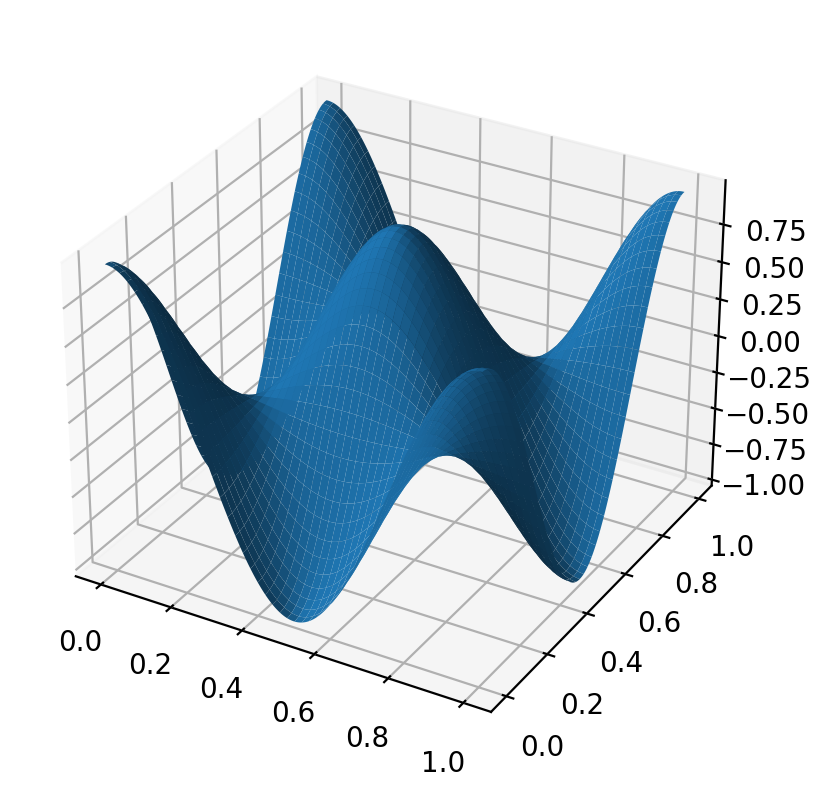

time taken:  24.064417600631714
neuron num 		 error 		 order
4 		 0.503048 		 * 		 6.171461 		 * 

8 		 0.435577 		 0.207768 		 5.388359 		 0.195766 

16 		 0.137555 		 1.662920 		 2.588698 		 1.057619 

32 		 0.011140 		 3.626184 		 0.311256 		 3.056054 

64 		 0.001489 		 2.903223 		 0.076555 		 2.023530 

128 		 0.000266 		 2.483335 		 0.019466 		 1.975568 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order & 	 $ | u -u_n |_{H^1}$ & 	 order \\ \hline \hline 
4 		 & 0.503048 &		 * & 		 6.171461 & 		 *  \\ \hline  

8 		 &  4.356e-01 &  		 0.21 &  		 5.388e+00 &  		 0.20 \\ \hline  

16 		 &  1.376e-01 &  		 1.66 &  		 2.589e+00 &  		 1.06 \\ \hline  

32 		 &  1.114e-02 &  		 3.63 &  		 3.113e-01 &  		 3.06 \\ \hline  

64 		 &  1.489e-03 &  		 2.90 &  		 7.656e-02 &  		 2.02 \\ \hline  

128 		 &  2.663e-04 &  		 2.48 &  		 1.947e-02 &  		 1.98 \\ \hline  



In [14]:
freq = 2 
# def u_exact(x):
#     return torch.sin(freq*pi*x[:,0:1])*torch.sin(freq*pi*x[:,1:2])
# def u_exact_approx(x):
#     return torch.sin(freq*pi*x[:,0:1])*torch.sin(freq*pi*x[:,1:2])*0.5 

# def u_exact_grad():
#     def u_grad_x(x):
#         return freq*pi*torch.cos(freq*pi*x[:,0:1])*torch.sin(freq*pi*x[:,1:2])
#     def u_grad_y(x):
#         return freq*pi*torch.sin(freq*pi*x[:,0:1])*torch.cos(freq*pi*x[:,1:2]) 

#     u_grad=[] 
#     u_grad.append(u_grad_x)
#     u_grad.append(u_grad_y)
#     return u_grad

# def laplace_u_exact(x):
#     return -2*(freq*pi)**2 * torch.sin(freq*pi*x[:,0:1])*torch.sin(freq*pi*x[:,1:2]) 
# def rhs(x):
#     return  -laplace_u_exact(x) + u_exact(x)**3 

# def g_N(dim):
#     u_grad = u_exact_grad() 
#     bcs_N = []
#     for i in range(dim):
#         bcs_N.append((i, u_grad[i]))
#     return bcs_N

def u_exact(x):
    return torch.cos(freq*pi*x[:,0:1])*torch.cos(freq*pi*x[:,1:2])


def u_exact_grad():
    def u_grad_x(x):
        return -freq*pi*torch.sin(freq*pi*x[:,0:1])*torch.cos(freq*pi*x[:,1:2])
    def u_grad_y(x):
        return -freq*pi*torch.cos(freq*pi*x[:,0:1])*torch.sin(freq*pi*x[:,1:2]) 

    u_grad=[] 
    u_grad.append(u_grad_x)
    u_grad.append(u_grad_y)
    return u_grad

def laplace_u_exact(x):
    return -2*(freq*pi)**2 * torch.cos(freq*pi*x[:,0:1])*torch.cos(freq*pi*x[:,1:2]) 
def rhs(x):
    return  -laplace_u_exact(x) + nonlinear(u_exact(x)) 

g_N = None 
# def g_N(dim):
#     return None 
#     u_grad = u_exact_grad() 
#     bcs_N = []
#     for i in range(dim):
#         bcs_N.append((i, u_grad[i]))
#     return bcs_N

function_name = "sin2pix" 
filename_write = "data-neumann/2DOGA-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 
save = False 
relu_k = 3
for N_list in [[2*5,2**5]]: # ,[2**6,2**6],[2**7,2**7] 
    # save = True 
    f_write = open(filename_write, "a")
    my_model = None 
    Nx = 400  
    order = 2
    exponent = 7
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
    N = np.prod(N_list)
    err_QMC2, err_h10, my_model = CGANonlinearPoissonReLU2D(my_model,rhs,u_exact, u_exact_grad,g_N, N_list,num_epochs,plot_freq, Nx, order, k = relu_k, rand_deter = 'rand', linear_solver = "direct")
    if save: 
        folder = 'data-neumann/'
        filename = folder + 'err_OGA_2D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data-neumann/'
        filename = folder + 'model_OGA_2D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)

    show_convergence_order(err_QMC2,err_h10,exponent,N,filename_write,False)
    show_convergence_order_latex(err_QMC2,err_h10,exponent)

In [19]:
## 
k = 3
d =2 
l2_order = 0.5 + (2*k+1)/(2*d)
print(l2_order)
h1_order = 0.5 + (2*(k-1)+1)/(2*d)
print(h1_order)

2.25
1.75


In [ ]:
Nx = 50   
order = 3 
gw_expand, integration_points = PiecewiseGQ2D_weights_points(Nx, order)
my_model = model(2,100,1,2).to(device)
my_model = adjust_neuron_position(my_model) 
def target(x):
    z = (2 * pi**2 + 1)*torch.cos(pi*x[:,0:1])*torch.cos(pi*x[:,1:2] )
    return z  
solver = 'direct'
sol = minimize_linear_layer_H1_explicit_assemble_efficient(my_model,target,gw_expand, integration_points,activation = 'relu',solver = solver)
my_model.fc2.weight.data[0,:] = sol[:] 
plot_2D(my_model.cpu())  